!!!
Prima di runnare il codice:
1. creare una cartella "Dati_Romagna_Acque" nella parte personale di Drive
2. scaricare i DATAset presenti all'interno della cartella condivisa a tutti "Dati Romagna Acque"
3. inserirli dentro la cartella creata "Dati_Romagna_Acque"
4.  nei nomi dei file, sostituire gli spazi con "_" (es. Dati Ridracoli 2015-2024 -> Dati_Ridracoli_2015-2024)

# Librerie

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from datetime import datetime
import statistics
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from datetime import timedelta
import calendar
import statsmodels.api as sm4
from datetime import datetime
import calendar
import random
from tqdm import tqdm
import math

#Accesso al Dataset

In [ ]:
# Collegamento Google Drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Dati_Romagna_Acque"

Mounted at /content/drive
Dati_Ridracoli_2015-2024.xlsx  Script_RomagnaAcque.pdf


## Caricamento dataset iniziale

In [ ]:
file_path = '/content/drive/My Drive/Dati_Romagna_Acque/Dati_Ridracoli_2015-2024.xlsx'
df = pd.read_excel(file_path)
pd.set_option('display.float_format', '{:.2f}'.format)

Colonne DATA

In [ ]:
# Creazione di una colonna per anno-MESE
df["ANNO-MESE"] = df["DATA"].dt.to_period("M")
df["ANNO"] = df["DATA"].dt.to_period("Y")
df["MESE"] = df["DATA"].dt.month
df['GIORNO'] = df['DATA'].dt.day
df['GIORNO_ANNO'] = df['DATA'].dt.dayofyear
df['GIORNO_SETTIMANA'] = df['DATA'].dt.dayofweek + 1

In [ ]:
# Rinomina le colonne rimuovendo spazi extra
df.columns = df.columns.str.strip()  # Rimuove spazi iniziali e finali
df.columns = df.columns.str.replace(r"\s+", " ", regex=True)  # Sostituisce spazi multipli con uno solo
df.columns = df.columns.str.replace(" ", "_")  # Sostituisce gli spazi con underscore

# Controlla il risultato
print(df.columns)
print(df.info)

Index(['DATA', 'ANNO', 'MESE', 'Livello_invaso_(m_s.l.m.)',
       'Volume_invaso_(m3)', 'Pioggia_Ridracoli_(mm)',
       'Apporto_medio_giornaliero_(mc/s)', 'Volume_sfiorato_giornaliero_(m3)',
       'Apporto_medio_giornaliero_netto_(mc/s)', 'ANNO-MESE', 'GIORNO',
       'GIORNO_ANNO', 'GIORNO_SETTIMANA'],
      dtype='object')
<bound method DataFrame.info of                     DATA  ANNO  MESE  Livello_invaso_(m_s.l.m.)  \
0    2015-01-01 08:00:00  2015     1                     548.32   
1    2015-01-02 08:00:00  2015     1                     548.23   
2    2015-01-03 08:00:00  2015     1                     548.22   
3    2015-01-04 08:00:00  2015     1                     548.53   
4    2015-01-05 08:00:00  2015     1                     548.76   
...                  ...   ...   ...                        ...   
3648 2024-12-27 08:00:00  2024    12                     554.93   
3649 2024-12-28 08:00:00  2024    12                     554.97   
3650 2024-12-29 08:00:00  2024    

# Prelievo


## Prelievi minimi mensili

In [ ]:
prelievi_minimi_mensili = [0.499, 0.569, 0.517, 0.486, 0.769, 0.974, 1.374, 1.325, 1.1015, 0.659, 0.532, 0.525]

# Mappa mese -> valore prelievo
mappa_prelievi = {mese: valore for mese, valore in zip(range(1, 13), prelievi_minimi_mensili)}

# Colonna con i prelievi minimi originali
df['Prelievo_minimo_mensile_(mc/s)'] = df['MESE'].map(mappa_prelievi)

## Finto 'Prelievo_medio_giornaliero_(mc/s)'

In [ ]:
pd.options.display.float_format = '{:.2f}'.format  # mostra 2 decimali sempre

#Crea la nuova colonna nel DataFrame
df['Finto_Prelievo_medio_giornaliero_(mc/s)'] = df['Apporto_medio_giornaliero_(mc/s)'].mean()

df['Reale_Prelievo_medio_giornaliero_(mc/s)'] = -(((df['Volume_invaso_(m3)'].shift(-1) - df['Volume_invaso_(m3)']) / 86400) - df['Apporto_medio_giornaliero_netto_(mc/s)'])

df['Reale_Prelievo_medio_giornaliero_(mc/s)'].describe()

,Reale_Prelievo_medio_giornaliero_(mc/s)
count,3652.00
mean,1.86
std,1.62
min,-19.52
25%,1.50
50%,1.86
75%,2.13
max,31.42


# df_mensile

Giorni in un mese

In [ ]:
# Raggruppamento per mese
df_mensile = df.groupby(["ANNO-MESE","ANNO","MESE"])[['Apporto_medio_giornaliero_(mc/s)','Finto_Prelievo_medio_giornaliero_(mc/s)']].mean().reset_index()
df_mensile["ANNO-MESE"] = df_mensile["ANNO-MESE"].dt.to_timestamp()  # Conversione in datetime

df_mensile['Apporto_medio_mensile_(mc/m)'] = df_mensile['Apporto_medio_giornaliero_(mc/s)']* 86400 * 30.44
df_mensile['Finto_Prelievo_medio_mensile_(mc/m)'] = df_mensile['Finto_Prelievo_medio_giornaliero_(mc/s)']* 86400 * 30.44

# Statistiche descrittive
print(df_mensile[['Apporto_medio_mensile_(mc/m)','Finto_Prelievo_medio_mensile_(mc/m)']].describe())
df_mensile[df_mensile['MESE'] == 6]

       Apporto_medio_mensile_(mc/m)  Finto_Prelievo_medio_mensile_(mc/m)
count                        120.00                               120.00
mean                     5173083.04                           5145981.11
std                      5228732.44                                 0.00
min                      -106440.11                           5145981.11
25%                       403588.73                           5145981.11
50%                      3359840.25                           5145981.11
75%                      8863392.82                           5145981.11
max                     20019524.12                           5145981.11


,ANNO-MESE,ANNO,MESE,Apporto_medio_giornaliero_(mc/s),Finto_Prelievo_medio_giornaliero_(mc/s),Apporto_medio_mensile_(mc/m),Finto_Prelievo_medio_mensile_(mc/m)
5,2015-06-01,2015,6,0.52,1.96,1378216.78,5145981.11
17,2016-06-01,2016,6,0.77,1.96,2021888.36,5145981.11
29,2017-06-01,2017,6,0.12,1.96,315895.57,5145981.11
41,2018-06-01,2018,6,0.38,1.96,988531.85,5145981.11
53,2019-06-01,2019,6,1.08,1.96,2851369.91,5145981.11
65,2020-06-01,2020,6,0.70,1.96,1852758.21,5145981.11
77,2021-06-01,2021,6,0.52,1.96,1371927.86,5145981.11
89,2022-06-01,2022,6,0.19,1.96,509388.69,5145981.11
101,2023-06-01,2023,6,1.59,1.96,4189524.01,5145981.11
113,2024-06-01,2024,6,1.03,1.96,2713230.14,5145981.11


# Apporto

## EDA

count   120.00
mean      1.97
std       1.99
min      -0.04
25%       0.15
50%       1.28
75%       3.37
max       7.61
Name: Apporto_medio_giornaliero_(mc/s), dtype: float64


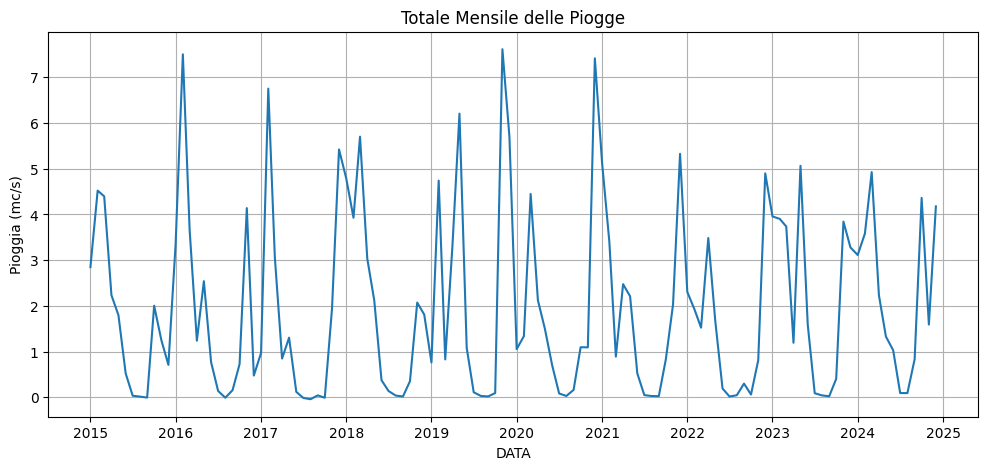

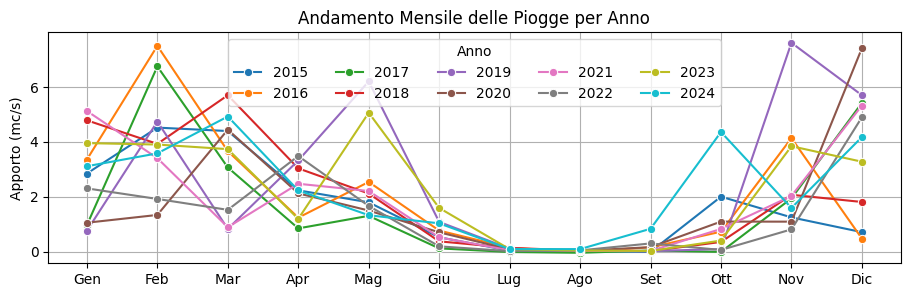

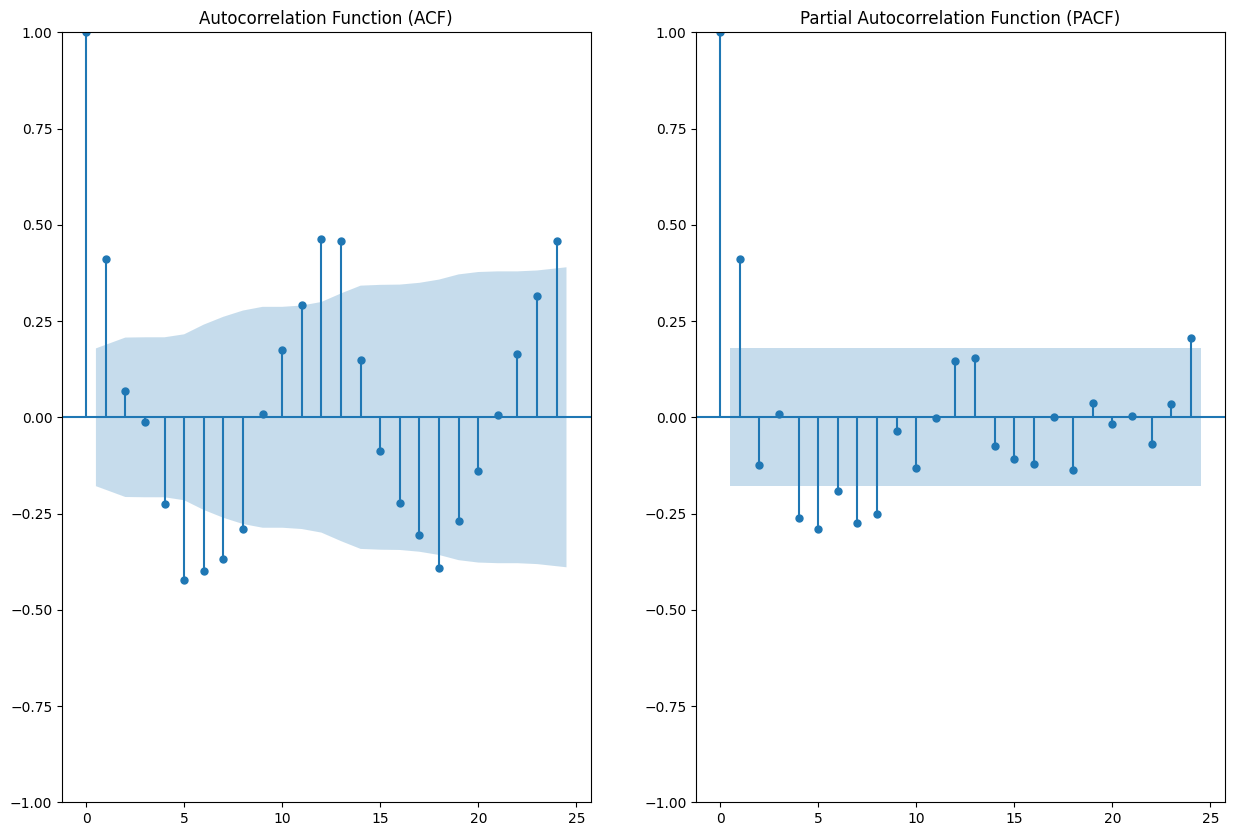

In [ ]:
# Raggruppamento per mese
df_mensile_apporto = df_mensile[["ANNO-MESE","ANNO","MESE",'Apporto_medio_giornaliero_(mc/s)']]

# Statistiche descrittive
print(df_mensile_apporto['Apporto_medio_giornaliero_(mc/s)'].describe())


# Plot della serie temporale
plt.figure(figsize=(12, 5))
sns.lineplot(x=df_mensile_apporto["ANNO-MESE"], y=df_mensile_apporto['Apporto_medio_giornaliero_(mc/s)'])
plt.title("Totale Mensile delle Piogge")
plt.xlabel("DATA")
plt.ylabel("Pioggia (mc/s)")
plt.grid()
plt.show()


# Plot con mesi sull'asse x e linee per anno
plt.figure(figsize=(11, 3), dpi=100)
sns.lineplot(data=df_mensile_apporto, x="MESE", y='Apporto_medio_giornaliero_(mc/s)', hue="ANNO", marker="o")
plt.title("Andamento Mensile delle Piogge per Anno")
plt.ylabel("Apporto (mc/s)")
plt.xlabel("")  # Rimuove l'etichetta "MESE" dall'asse x
plt.xticks(ticks=range(1, 13), labels=["Gen", "Feb", "Mar", "Apr", "Mag", "Giu", "Lug", "Ago", "Set", "Ott", "Nov", "Dic"])
plt.grid()

# Legenda in alto, centrata e orizzontale
plt.legend(title="Anno", loc='best', ncol=5)

plt.show()


# ACF e PACF per analisi della stagionalità
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
plot_acf(df_mensile_apporto['Apporto_medio_giornaliero_(mc/s)'], lags=24, ax=ax[0])
plot_pacf(df_mensile_apporto['Apporto_medio_giornaliero_(mc/s)'], lags=24, ax=ax[1])
ax[0].set_title("Autocorrelation Function (ACF)")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()


## Forecasting Apporto_medio_giornaliero_(mc/s) (2 anni)

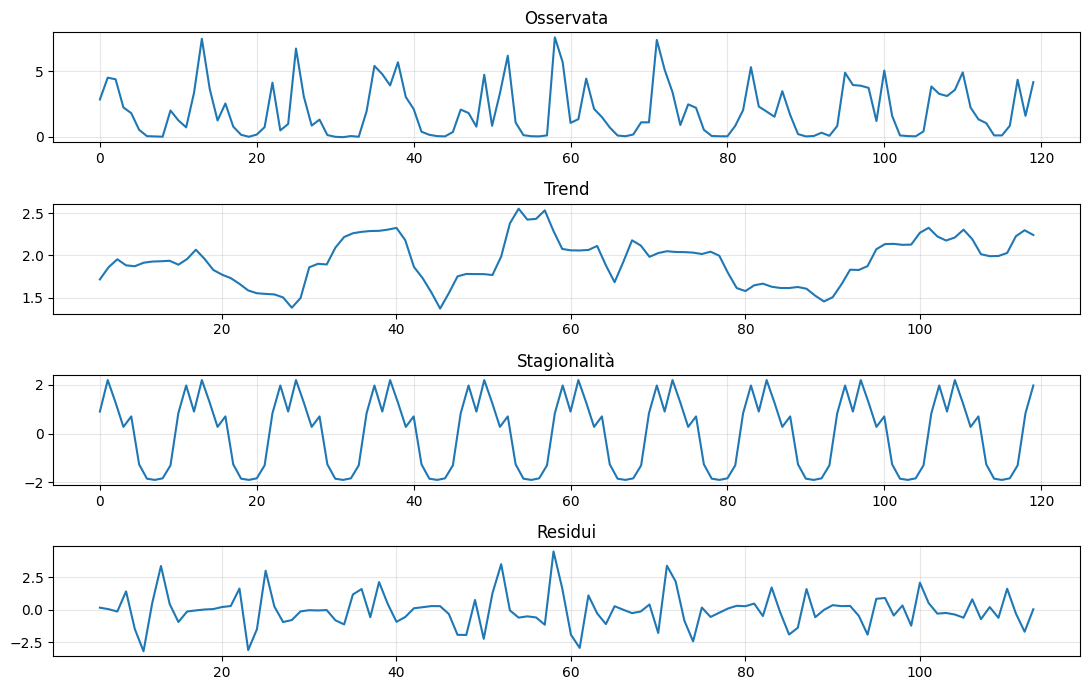

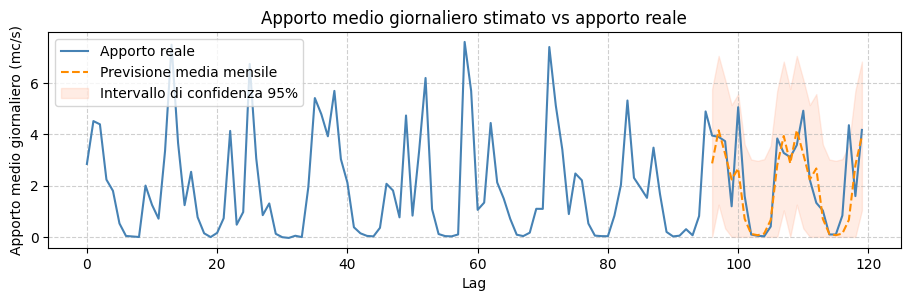

Lunghezza della serie temporale: 120
Forma del pattern stagionale: (12,)
Valori del forecast per i due anni di test:
[[2.86993931 4.16219418 3.23730774 2.24164337 2.67125243 0.70464235
  0.11537072 0.0660567  0.13081731 0.66286908 2.80177926 3.93940464]
 [2.86993931 4.16219418 3.23730774 2.24164337 2.67125243 0.70464235
  0.11537072 0.0660567  0.13081731 0.66286908 2.80177926 3.93940464]]


In [ ]:
# Serie temporale
ts = df_mensile_apporto['Apporto_medio_giornaliero_(mc/s)']

# Decomposizione stagionale
decomposition = seasonal_decompose(ts, model='additive', period=12)

# Crea indici numerici per la visualizzazione
indices = np.arange(len(ts))

# Plot della decomposizione
plt.figure(figsize=(11, 7), dpi=100)

plt.subplot(411)
plt.plot(indices, decomposition.observed)
plt.title('Osservata', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(indices, decomposition.trend)
plt.title('Trend', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(indices, decomposition.seasonal)
plt.title('Stagionalità', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(indices, decomposition.resid)
plt.title('Residui', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Calcolare la media della componente stagionale per ogni mese
seasonal_pattern = decomposition.seasonal[:12].values  # Pattern stagionale per 12 mesi

# Aggiunta della media della serie per centrare il forecast
mean_trend = decomposition.trend.mean()  # Media della componente di trend
mean_series = ts.mean()  # Media della serie originale

# Creare la previsione ripetendo il pattern stagionale per tutta la serie
n_periods = len(ts) // 12  # Numero di anni completi nella serie
forecast = np.tile(seasonal_pattern, n_periods)  # Ripete il pattern stagionale

# Aggiungere eventuali mesi rimanenti
if len(ts) % 12 != 0:
    forecast = np.concatenate([forecast, seasonal_pattern[:len(ts) % 12]])

# Centrare il forecast aggiungendo la media della serie
forecast += mean_series

# Impostare il periodo di test (ultimo anno di dati)
train = ts[:-24]  # Dati di addestramento
test = ts[-24:]   # Dati di test

# Previsione per il periodo di test
forecast_test = forecast[-24:]
forecast_test = np.maximum(forecast_test, 0)

# Calcolo degli intervalli di confidenza
std_seasonal = decomposition.seasonal.std()  # Deviazione standard della stagionalità
lower_bound = forecast_test - 1.96 * std_seasonal  # Limite inferiore
lower_bound = np.maximum(lower_bound, 0)
upper_bound = forecast_test + 1.96 * std_seasonal  # Limite superiore

# Visualizzazione dei risultati con nuovi colori
plt.figure(figsize=(11, 2.8))
plt.plot(ts.index, ts, label='Apporto reale', color='steelblue')
plt.plot(test.index, forecast_test, label='Previsione media mensile', color='darkorange', linestyle='--')
plt.fill_between(test.index, lower_bound, upper_bound, color='lightsalmon', alpha=0.2, label='Intervallo di confidenza 95%')
plt.title('Apporto medio giornaliero stimato vs apporto reale')
plt.ylabel('Apporto medio giornaliero (mc/s)')
plt.xlabel('Lag')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Lunghezza della serie temporale:", len(ts))
print("Forma del pattern stagionale:", seasonal_pattern.shape)
print("Valori del forecast per i due anni di test:")
print(forecast_test.reshape(2, 12))  # Riorganizza in 2 anni x 12 mesi

# Selezione della data di partenza

In [ ]:
oggi = datetime(2025, 1, 1) # Data di oggi
oggi_test = oggi.replace(year=oggi.year - 2)  # Stessa data, due anni prima
mese_corrente = oggi_test.month # Mese attuale (1-12)

# Definire la prima data futura (il mese successivo a oggi)
prima_data_futura = oggi_test.replace(day=1) + pd.DateOffset(months=1)


# df_forecast

Partenza 01/01/2023

In [ ]:
df_forecast = df_mensile[-24:].copy()
df_forecast['Forecast_Apporto_medio_giornaliero_(mc/s)'] = forecast_test
df_forecast['Forecast_Apporto_medio_mensile_(mc/m)'] = (
    df_forecast['Forecast_Apporto_medio_giornaliero_(mc/s)'] * 86400 * 30.44
)

df_forecast.head()


,ANNO-MESE,ANNO,MESE,Apporto_medio_giornaliero_(mc/s),Finto_Prelievo_medio_giornaliero_(mc/s),Apporto_medio_mensile_(mc/m),Finto_Prelievo_medio_mensile_(mc/m),Forecast_Apporto_medio_giornaliero_(mc/s),Forecast_Apporto_medio_mensile_(mc/m)
96,2023-01-01,2023,1,3.96,1.96,10404019.13,5145981.11,2.87,7547986.31
97,2023-02-01,2023,2,3.90,1.96,10265493.22,5145981.11,4.16,10946637.29
98,2023-03-01,2023,3,3.74,1.96,9826168.95,5145981.11,3.24,8514171.14
99,2023-04-01,2023,4,1.19,1.96,3140439.70,5145981.11,2.24,5895557.94
100,2023-05-01,2023,5,5.06,1.96,13316787.69,5145981.11,2.67,7025436.64


In [ ]:
# Esegui il merge tra df e il sottoinsieme di df_forecast
df_forecast_subset = df_forecast[['MESE', 'Forecast_Apporto_medio_giornaliero_(mc/s)']].head(12)
df = pd.merge(df, df_forecast_subset, on='MESE', how='left')

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   DATA                                       3653 non-null   datetime64[ns]
 1   ANNO                                       3653 non-null   period[Y-DEC] 
 2   MESE                                       3653 non-null   int32         
 3   Livello_invaso_(m_s.l.m.)                  3653 non-null   float64       
 4   Volume_invaso_(m3)                         3653 non-null   int64         
 5   Pioggia_Ridracoli_(mm)                     3653 non-null   float64       
 6   Apporto_medio_giornaliero_(mc/s)           3653 non-null   float64       
 7   Volume_sfiorato_giornaliero_(m3)           3653 non-null   float64       
 8   Apporto_medio_giornaliero_netto_(mc/s)     3653 non-null   float64       
 9   ANNO-MESE          

# Algoritmo per Target Mensile del Volume invaso

              MESE  Volume Target Ideale (m³)  Volume Target Fattibile (m³)  \
0     January 2023                 16,150,412                    16,150,412   
1    February 2023                 18,550,881                    18,550,881   
2       March 2023                 24,341,005                    24,341,005   
3       April 2023                 27,724,600                    27,709,195   
4         May 2023                 28,464,622                    28,458,772   
5        June 2023                 30,349,932                    30,338,228   
6        July 2023                 27,051,591                    27,051,591   
7      August 2023                 22,209,633                    22,209,633   
8   September 2023                 17,227,159                    17,237,383   
9     October 2023                 13,151,132                    13,151,132   
10   November 2023                 13,147,691                    13,147,691   
11   December 2023                 13,121,712       

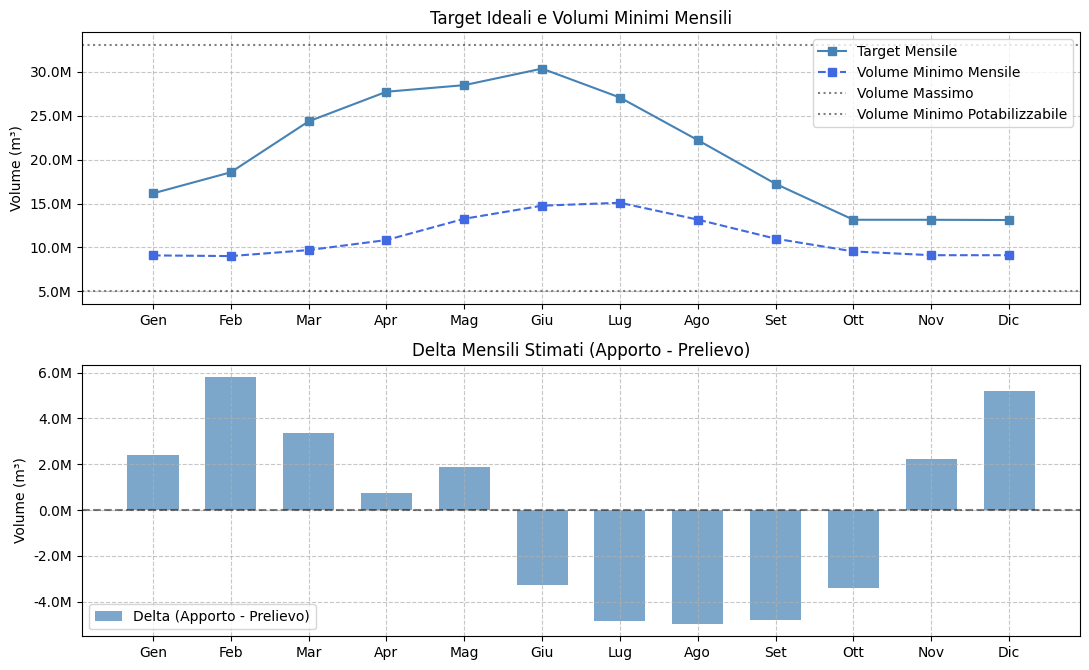

In [ ]:
def calcola_volume_minimo(mese_corrente, prelievi_minimi_mensili, secondi_al_giorno=86400, anno_corrente=None):

    # Se non è specificato l'anno, usa l'anno corrente dalla variabile globale
    if anno_corrente is None:
        anno_corrente = oggi_test.year

    # Calcola i prossimi tre mesi (includendo il mese corrente)
    mesi = []
    for i in range(3):
        mese = ((mese_corrente - 1 + i) % 12) + 1  # Assicura che il mese sia tra 1 e 12
        mesi.append(mese)

    # Calcola il volume totale necessario per i prelievi minimi nei prossimi tre mesi
    volume_minimo = 5_000_000
    for mese in mesi:
        # Ottieni il numero di giorni nel mese
        giorni_nel_mese = calendar.monthrange(anno_corrente, mese)[1]

        # Calcola il volume necessario per questo mese
        # prelievo_minimo (mc/s) * secondi_al_giorno * giorni_nel_mese
        volume_mese = prelievi_minimi_mensili[mese - 1] * secondi_al_giorno * giorni_nel_mese
        volume_minimo += volume_mese

    return volume_minimo

def calcola_target_mensile_feasible(apporto, prelievo, mese_iniziale, prelievi_minimi_mensili, oggi_test):

    # Anno corrente per calcoli precisi dei giorni nei mesi
    anno_corrente = oggi_test.year

    # Mese iniziale in formato 1-12 per calcoli successivi
    mese_iniziale_1_12 = mese_iniziale + 1

    # Calcolo di tutti i volumi minimi necessari per ogni mese
    volumi_minimi_necessari = []
    for i in range(12):
        MESE_1_12 = (mese_iniziale_1_12 + i - 1) % 12 + 1  # Mese in formato 1-12
        volume_minimo_garanzia = calcola_volume_minimo(MESE_1_12, prelievi_minimi_mensili, anno_corrente=anno_corrente)
        volumi_minimi_necessari.append(volume_minimo_garanzia)

    # Limiti operativi della diga
    MIN_VOLUME = min(volumi_minimi_necessari)  # Prendiamo il minimo tra tutti i volumi minimi necessari
    MAX_VOLUME = 33062336

    # Primo passaggio: calcolo dei target ideali senza vincolo di fattibilità
    volumi_target_ideali = []

    for i in range(12):
        MESE = (mese_iniziale + i) % 12  # Mese in formato 0-11
        MESE_1_12 = (mese_iniziale_1_12 + i - 1) % 12 + 1  # Mese in formato 1-12

        # Calcola il volume minimo necessario per i prelievi minimi dei prossimi 3 mesi
        volume_minimo_garanzia = volumi_minimi_necessari[i]

        # Assicuriamoci di avere abbastanza dati per la finestra
        if i + 13 <= len(apporto):
            apporto_finestra = apporto[i:i+13]
            prelievo_finestra = prelievo[i:i+13]
        else:
            apporto_finestra = np.pad(apporto[i:], (0, 13 - len(apporto[i:])), mode='edge')
            prelievo_finestra = np.pad(prelievo[i:], (0, 13 - len(prelievo[i:])), mode='edge')

        best_target = None
        min_sforamento = float('inf')

        # Il target minimo deve essere almeno MIN_VOLUME o il volume di garanzia, il maggiore dei due
        target_minimo_effettivo = max(MIN_VOLUME, volume_minimo_garanzia)

        for possibile_target in np.linspace(target_minimo_effettivo, MAX_VOLUME, 1000):  # Testiamo 1000 valori
            volume_futuro = possibile_target
            sforamento_totale = 0

            # Simulazione per verificare che non ci siano problemi nei mesi successivi
            for j in range(13):  # Osserviamo i 13 mesi successivi
                volume_futuro += apporto_finestra[j] - prelievo_finestra[j]
                if volume_futuro < MIN_VOLUME:
                    sforamento_totale += (MIN_VOLUME - volume_futuro) ** 3
                    volume_futuro = MIN_VOLUME
                elif volume_futuro > MAX_VOLUME:
                    sforamento_totale += (volume_futuro - MAX_VOLUME)
                    volume_futuro = MAX_VOLUME

            # Verifica che il volume iniziale sia sufficiente per garantire i prelievi minimi
            # nei 3 mesi successivi in assenza di apporto
            volume_test = possibile_target
            vincolo_prelievi_rispettato = True

            # Test con scenario di apporto zero
            for j in range(1, 4):  # Per i prossimi 3 mesi
                mese_futuro = (MESE_1_12 + j - 1) % 12 + 1
                giorni_nel_mese = calendar.monthrange(anno_corrente, mese_futuro)[1]
                prelievo_minimo_mese = prelievi_minimi_mensili[mese_futuro - 1] * 86400 * giorni_nel_mese

                volume_test -= prelievo_minimo_mese
                if volume_test < MIN_VOLUME:
                    vincolo_prelievi_rispettato = False
                    break

            # Se il vincolo dei prelievi minimi non è rispettato, aumentiamo lo sforamento
            if not vincolo_prelievi_rispettato:
                sforamento_totale += 1e10  # Penalità molto alta

            if sforamento_totale < min_sforamento:
                min_sforamento = sforamento_totale
                best_target = possibile_target

        volumi_target_ideali.append(best_target)

    # Secondo passaggio: adattamento per garantire la fattibilità delle transizioni
    volumi_target_fattibili = volumi_target_ideali.copy()

    # Iteriamo in avanti per garantire che le transizioni siano fattibili
    for i in range(11):  # Per i primi 11 mesi (l'ultimo non ha un "successivo")
        indice_mese_corrente = (mese_iniziale + i) % 12
        indice_mese_successivo = (mese_iniziale + i + 1) % 12
        mese_successivo_1_12 = (mese_iniziale_1_12 + i) % 12 + 1

        # Calcolo del delta massimo realizzabile tra il mese corrente e il successivo
        delta_realizzabile = apporto[i] - prelievo[i]

        # Calcolo della differenza tra i target ideali
        differenza_target = volumi_target_fattibili[i+1] - volumi_target_fattibili[i]

        # Se la differenza non è fattibile, adattiamo il target del mese successivo
        if abs(differenza_target) > abs(delta_realizzabile):
            if differenza_target > 0:  # Se il target successivo è maggiore
                # Limitiamo l'incremento a quanto realizzabile
                volumi_target_fattibili[i+1] = volumi_target_fattibili[i] + delta_realizzabile
            else:  # Se il target successivo è minore
                # Limitiamo il decremento a quanto realizzabile
                volumi_target_fattibili[i+1] = volumi_target_fattibili[i] + delta_realizzabile

        # Verifica che il nuovo target soddisfi il vincolo dei prelievi minimi
        volume_minimo_necessario = volumi_minimi_necessari[(i+1) % 12]

        # Se il target è inferiore al volume minimo necessario, lo aumentiamo
        if volumi_target_fattibili[i+1] < volume_minimo_necessario:
            volumi_target_fattibili[i+1] = volume_minimo_necessario

        # Assicuriamoci che il target rimanga entro i limiti
        volumi_target_fattibili[i+1] = max(MIN_VOLUME, min(MAX_VOLUME, volumi_target_fattibili[i+1]))

    # Calcolare la differenza tra target ideali e fattibili
    differenze = [abs(ideal - feasible) for ideal, feasible in zip(volumi_target_ideali, volumi_target_fattibili)]

    return volumi_target_fattibili, volumi_target_ideali, differenze, volumi_minimi_necessari

# Esempio di utilizzo del codice completo

# Definizione dei prelievi minimi mensili (mc/s)
prelievi_minimi_mensili = [0.499, 0.569, 0.517, 0.486, 0.769, 0.974, 1.374, 1.325, 1.1015, 0.659, 0.532, 0.525]

# Data di riferimento per il calcolo (1-1-2023)
oggi_test = pd.Timestamp('2023-01-01')

# Mese corrente (0-11 dove 0=gennaio)
mese_corrente = oggi_test.month - 1  # Gennaio = 0

# Simulazione dati
# Qui è necessario definire df_forecast prima di usarlo
# Per esempio:

apporto = df_forecast['Forecast_Apporto_medio_mensile_(mc/m)'].values
prelievo = df_forecast['Finto_Prelievo_medio_mensile_(mc/m)'].values

# Calcoliamo i volumi target con il nuovo algoritmo
volumi_target_fattibili, volumi_target_ideali, differenze, volumi_minimi_necessari = calcola_target_mensile_feasible(
    apporto,
    prelievo,
    mese_corrente,
    prelievi_minimi_mensili,
    oggi_test
)

# Creiamo la lista dei mesi a partire da gennaio 2023
mesi = pd.date_range(oggi_test.replace(day=1), periods=12, freq='MS').strftime('%B %Y')

# Creiamo il DataFrame con i risultati comparativi
df_risultati = pd.DataFrame({
    'MESE': mesi,
    'Volume Target Ideale (m³)': volumi_target_ideali,
    'Volume Target Fattibile (m³)': volumi_target_fattibili,
    'Volume Minimo Necessario (m³)': volumi_minimi_necessari,
})

# Formattazione dei numeri per una migliore leggibilità
pd.options.display.float_format = '{:,.0f}'.format
print(df_risultati)

# Grafici

# Funzione per formattare i numeri in milioni
def millions(x, pos):
    'Formatta i numeri in milioni'
    return f'{x/1e6:.1f}M'

# Definizione delle date di inizio e fine
data_inizio = oggi_test
data_fine = data_fine = oggi_test + timedelta(days=364)

# Supponiamo che 'mesi' contenga i mesi tra la data di inizio e la data di fine
# Creiamo una lista di date per ogni mese
mesi = [data_inizio + timedelta(days=30.44*i) for i in range(12)]  # Lista dei mesi (approssimativamente ogni 30 giorni)

# Lista delle abbreviazioni italiane dei mesi
etichette_mesi = ["Gen", "Feb", "Mar", "Apr", "Mag", "Giu",
                  "Lug", "Ago", "Set", "Ott", "Nov", "Dic"]

# Creazione del grafico comparativo con volumi minimi
fig, axs = plt.subplots(2, 1, figsize=(11,6.8), dpi=100, sharex=True)
axs[0].tick_params(labelbottom=True)

# Grafico dei volumi target
axs[0].plot(mesi, volumi_target_fattibili, marker='s', linestyle='-', color='steelblue', label="Target Mensile")
axs[0].plot(mesi, volumi_minimi_necessari, marker='s', linestyle='--', color='royalblue', label="Volume Minimo Mensile")
axs[0].axhline(y=33062336, color='black', linestyle=':', alpha=0.5, label="Volume Massimo")
axs[0].axhline(y=5_000_000, color='black', linestyle=':', alpha=0.5, label="Volume Minimo Potabilizzabile")

axs[0].set_ylabel("Volume (m³)")
axs[0].set_title("Target Ideali e Volumi Minimi Mensili")
axs[0].tick_params(axis='x', rotation=0)
axs[0].grid(True, linestyle="--", alpha=0.7)
axs[0].legend()
axs[0].yaxis.set_major_formatter(FuncFormatter(millions))

# Grafico dei delta mensili
larghezza_barra = 20
axs[1].bar(mesi, [apporto[i] - prelievo[i] for i in range(12)], color='steelblue', alpha=0.7, label="Delta (Apporto - Prelievo)", width=larghezza_barra)
axs[1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

axs[1].set_ylabel("Volume (m³)")
axs[1].set_title("Delta Mensili Stimati (Apporto - Prelievo)")
axs[1].tick_params(axis='x', rotation=0)
axs[1].grid(True, linestyle="--", alpha=0.7)
axs[1].legend()
axs[1].yaxis.set_major_formatter(FuncFormatter(millions))

# Etichette asse X (mesi) – solo alla fine, dopo entrambi i grafici
plt.xticks(ticks=mesi, labels=etichette_mesi)

plt.tight_layout()
plt.show()



In [ ]:
# Esegui il merge tra df e il sottoinsieme di df_forecast
df_forecast['Volume Target Ideale (m³)'] = (volumi_target_fattibili * (len(df_forecast) // len(volumi_target_fattibili))) + volumi_target_fattibili[:len(df_forecast) % len(volumi_target_fattibili)]

df_forecast_subset2 = df_forecast[['MESE', 'Volume Target Ideale (m³)']].head(12)

df = pd.merge(df, df_forecast_subset2, on='MESE', how='left')

 # Algoritmo per prelievo giornaliero ottimizzato
Simula giorno per giorno la gestione del prelievo d'acqua da una diga

1. Garantire che il volume della diga raggiunga un obiettivo target due mesi nel futuro.

2. Evitare variazioni troppo brusche nei prelievi.

3. Rispettare i limiti tecnici e ambientali: prelievo minimo e massimo consentito.

4. Tenere conto degli apporti previsti (cioè l’acqua che entrerà nella diga).

Bisogna considerare:

- Volume della diga attuale giornaliera
- Volume target mensile
- Forecast nostro Piogge mensili
- Forecast nostro Prelievi (dalla diga o totali) a distanza 7 giorni
- IN FUTURO Previsioni meteo acquistate Piogge a distanza 7 giorni

Target mensili: [np.float64(16.15), np.float64(18.55), np.float64(24.34), np.float64(27.71), np.float64(28.46), np.float64(30.34), np.float64(27.05), np.float64(22.21), np.float64(17.24), np.float64(13.15), np.float64(13.15), np.float64(13.12)] milioni di m³
Mese di inizio dati: 1 (Gennaio)
Data inizio simulazione: 2023-01-01 00:00:00 (Mese: Gennaio)
Giorno 0: Data=2023-01-01 00:00:00, Mese corrente=Gennaio (idx=0), Mese successivo=Febbraio (idx=1), Mese target=Marzo (idx=2)
Giorno 1: Data=2023-01-02 00:00:00, Mese corrente=Gennaio (idx=0), Mese successivo=Febbraio (idx=1), Mese target=Marzo (idx=2)
Giorno 2: Data=2023-01-03 00:00:00, Mese corrente=Gennaio (idx=0), Mese successivo=Febbraio (idx=1), Mese target=Marzo (idx=2)

===== RISULTATI MENSILI DELLA SIMULAZIONE =====
Volume e target espressi in milioni di metri cubi
Prelievi e apporti espressi in metri cubi al secondo


        Target_Mese_Corrente  Volume_mc  Target_Current_mc  Min_Volume_mc
Periodo                               

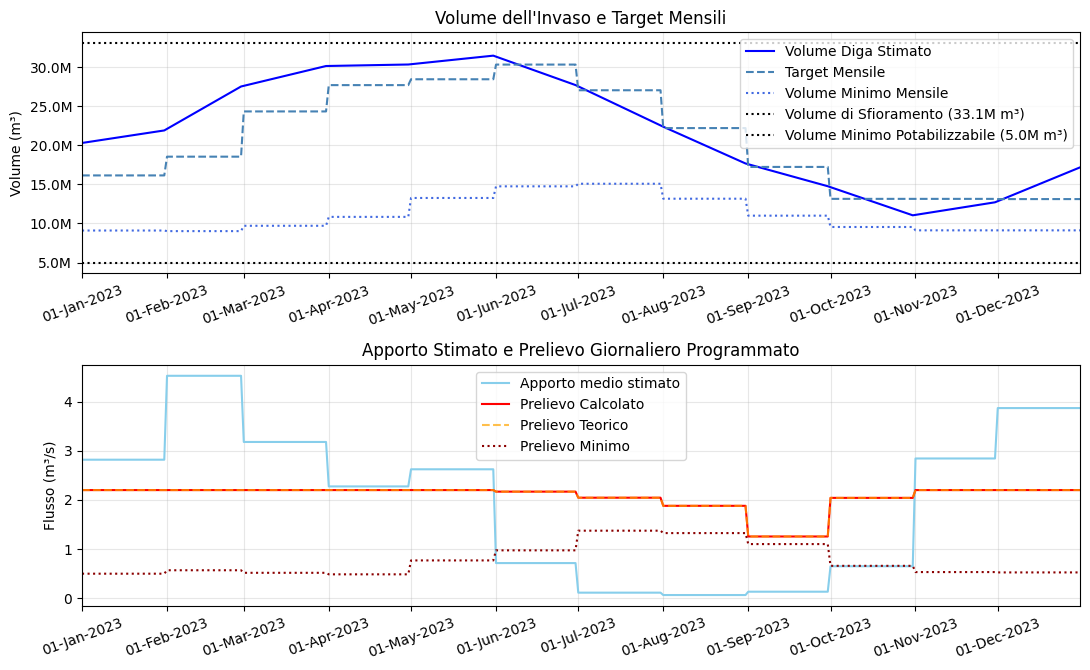

In [ ]:
def calcola_prelievo_giornaliero(volume_attuale, target_mese_futuro, forecast_apporto_mensile,
                                giorno_corrente, giorni_nel_mese, mese_corrente,
                                forecast_apporti_mensili, mese_inizio_dati, prelievi_minimi_mensili):

    # Calcolo giorni rimanenti nel mese corrente
    giorni_rimanenti = giorni_nel_mese - giorno_corrente + 1

    # Orizzonte di pianificazione: consideriamo i giorni rimanenti nel mese corrente
    # più tutti i giorni del mese successivo (per un totale di circa 2 mesi)

    # Calcolo dei giorni totali nell'orizzonte di pianificazione
    giorni_totali = giorni_rimanenti  # Giorni rimanenti nel mese corrente

    # Aggiungiamo i giorni del mese successivo
    mese_1 = (mese_corrente % 12) + 1  # Mese successivo (1-12)

    # Utilizziamo l'anno corrente per calcolare correttamente i giorni nei mesi
    anno_corrente = oggi_test.year
    giorni_totali += calendar.monthrange(anno_corrente, mese_1)[1]

    # Calcolo dell'apporto totale previsto nell'orizzonte di pianificazione
    apporto_totale = 0

    # Apporto del mese corrente (proporzionale ai giorni rimanenti)
    mese_corrente_idx_dati = (mese_corrente - mese_inizio_dati) % 12  # Convertire alla posizione nell'array

    # Verifica che l'indice sia valido
    mese_corrente_idx_dati = mese_corrente_idx_dati % len(forecast_apporti_mensili)

    apporto_totale += forecast_apporto_mensile * (giorni_rimanenti / giorni_nel_mese)

    # Apporto del mese successivo completo
    mese_1 = (mese_corrente % 12) + 1  # Mese successivo (1-12)
    mese_1_idx_dati = (mese_1 - mese_inizio_dati) % 12  # Posizione nell'array

    # Verifica che l'indice sia valido
    mese_1_idx_dati = mese_1_idx_dati % len(forecast_apporti_mensili)

    apporto_totale += forecast_apporti_mensili[mese_1_idx_dati]

    # Conversione dell'apporto totale in apporto giornaliero medio (mc/s)
    apporto_giornaliero_medio_mc_s = apporto_totale / (86400 * giorni_totali)

    # Calcolo del volume totale che deve essere aggiunto/sottratto per raggiungere il target
    delta_volume_necessario = target_mese_futuro - volume_attuale  # in metri cubi

    # Calcolo del bilancio idrico giornaliero necessario utilizzando i giorni totali
    bilancio_giornaliero_necessario_mc_s = delta_volume_necessario / (86400 * giorni_totali)

    # Il prelievo ottimale è l'apporto previsto meno il bilancio necessario
    prelievo_ottimale = apporto_giornaliero_medio_mc_s - bilancio_giornaliero_necessario_mc_s

    # Definizione dei limiti sul prelievo
    # Utilizzo del prelievo minimo specifico per il mese corrente invece di un valore statico
    prelievo_minimo = prelievi_minimi_mensili[mese_corrente - 1]  # -1 perché gli indici degli array iniziano da 0
    prelievo_massimo = 2.2  # mc/s, capacità massima delle strutture di uscita

    # Calcolo prelievo ottimale (limitato tra minimo e massimo)
    prelievo_ottimale = max(prelievo_minimo, min(prelievo_massimo, prelievo_ottimale))

    return prelievo_ottimale

def simula_gestione_diga(giorni_simulazione, volume_iniziale, target_mensili, forecast_apporti_mensili,
                        data_inizio, mese_inizio_dati, prelievi_minimi_mensili, volumi_minimi_necessari):

    risultati = []
    volume_corrente = volume_iniziale
    data_corrente = data_inizio  # Usiamo direttamente oggi_test come data di partenza

    # Variabili per tenere traccia del prelievo e del mese corrente
    prelievo_corrente = None
    mese_precedente = None

    # Nomi dei mesi italiani
    mesi = ["Gennaio", "Febbraio", "Marzo", "Aprile", "Maggio", "Giugno",
            "Luglio", "Agosto", "Settembre", "Ottobre", "Novembre", "Dicembre"]

    # Stampa i target mensili per debug
    print(f"Target mensili: {[round(vol/1e6,2) for vol in target_mensili]} milioni di m³")
    print(f"Mese di inizio dati: {mese_inizio_dati} ({mesi[mese_inizio_dati-1]})")
    print(f"Data inizio simulazione: {data_corrente} (Mese: {mesi[data_corrente.month-1]})")

    for _ in range(giorni_simulazione):
        # Determina il mese corrente direttamente dalla data
        mese_corrente = data_corrente.month  # 1-12
        giorno_corrente = data_corrente.day  # 1-31

        # Calcolo del giorno a metà mese (approssimato)
        giorni_nel_mese = calendar.monthrange(data_corrente.year, data_corrente.month)[1]
        meta_mese = (giorni_nel_mese // 2) + 1  # Giorno a metà mese (arrotondato)

        # Verifica se siamo passati a un nuovo mese
        cambio_mese = mese_corrente != mese_precedente if mese_precedente is not None else True

        # Verifica se siamo a metà mese
        meta_mese_raggiunta = giorno_corrente == meta_mese

        # IMPORTANTE: Correggiamo il calcolo dell'indice per i volumi minimi
        # Calcolo corretto dell'indice del mese corrente nell'array dei dati
        mese_corrente_idx = (mese_corrente - 1) % 12  # Le liste sono 0-based, il mese è 1-based
        volume_minimo_corrente = volumi_minimi_necessari[mese_corrente_idx]

        # Calcolo corretto degli indici dei mesi per target e apporti
        # Il mese successivo è 1 mese dopo il corrente
        mese_successivo = (mese_corrente % 12) + 1  # Mese successivo (1-12)
        mese_successivo_idx = (mese_successivo - 1) % 12  # Indice 0-based per il mese successivo

        # Il mese target è 2 mesi dopo il mese corrente
        mese_target = ((mese_corrente + 1) % 12) + 1  # Formula corretta per ottenere il mese 2 posizioni avanti (1-12)
        mese_target_idx = (mese_target - 1) % 12  # Indice 0-based per il mese target

        # Ottieni i nomi dei mesi per visualizzazione
        mese_corrente_nome = mesi[mese_corrente-1]  # -1 perché mesi è 0-based
        mese_successivo_nome = mesi[mese_successivo-1]  # -1 perché mesi è 0-based
        mese_target_nome = mesi[mese_target-1]  # -1 perché mesi è 0-based

        # Debug iniziale: stampa i primi giorni
        if _ < 3:
            print(f"Giorno {_}: Data={data_corrente}, Mese corrente={mese_corrente_nome} (idx={mese_corrente_idx}), "
                  f"Mese successivo={mese_successivo_nome} (idx={mese_successivo_idx}), "
                  f"Mese target={mese_target_nome} (idx={mese_target_idx})")

        # Ottieni i target per visualizzazione e calcolo
        target_corrente = target_mensili[mese_corrente_idx]
        target_successivo = target_mensili[mese_successivo_idx]
        target_futuro = target_mensili[mese_target_idx]

        # Ottieni la previsione di apporto per il mese corrente
        forecast_apporto_mensile = forecast_apporti_mensili[mese_corrente_idx]

        # Calcola il numero di giorni nel mese corrente usando l'anno della data corrente
        giorni_nel_mese = calendar.monthrange(data_corrente.year, data_corrente.month)[1]

        # Calcola il prelievo ottimale teorico
        prelievo_teorico = calcola_prelievo_giornaliero(
            volume_corrente,
            target_futuro,
            forecast_apporto_mensile,
            data_corrente.day,
            giorni_nel_mese,
            mese_corrente,
            forecast_apporti_mensili,
            mese_inizio_dati,
            prelievi_minimi_mensili
        )

        # Determina se dobbiamo modificare il prelievo corrente
        if prelievo_corrente is None or cambio_mese or meta_mese_raggiunta:
            # Primo giorno di simulazione, primo giorno del mese o metà mese: imposta il prelievo al valore calcolato
            prelievo_corrente = prelievo_teorico

        prelievo_applicato = prelievo_corrente

        # Simula l'effetto del prelievo e dell'apporto sul volume della diga
        apporto_giornaliero_mc_s = forecast_apporto_mensile / (86400 * giorni_nel_mese)
        delta_giornaliero = (apporto_giornaliero_mc_s - prelievo_applicato) * 86400  # mc/giorno
        volume_corrente += delta_giornaliero

        # Assicuriamoci che il volume non superi il massimo consentito
        if volume_corrente > MAX_VOLUME:
           volume_corrente = MAX_VOLUME

        # Registra i risultati
        risultati.append({
            'Data': data_corrente,
            'Volume': volume_corrente,
            'Target_Mese_Corrente': mese_corrente_nome,
            'Target_Mese_Successivo': mese_successivo_nome,
            'Target_Mese_Futuro': mese_target_nome,
            'Target_Volume_Corrente': target_corrente,
            'Target_Volume_Successivo': target_successivo,
            'Target_Volume_Futuro': target_futuro,
            'Apporto_Giornaliero_(mc/s)': apporto_giornaliero_mc_s,
            'Prelievo_Teorico_(mc/s)': prelievo_teorico,  # Prelievo teorico calcolato
            'Prelievo_Calcolato_(mc/s)': prelievo_applicato,  # Prelievo effettivamente applicato
            'Delta_Giornaliero_(mc)': delta_giornaliero,
            'Prelievo_Minimo_(mc/s)': prelievi_minimi_mensili[mese_corrente-1],
            'Volume_Minimo_Dinamico': volume_minimo_corrente,
            'mese_corrente_idx': mese_corrente_idx,
            'mese_successivo_idx': mese_successivo_idx,
            'mese_target_idx': mese_target_idx
        })

        # Aggiorna il mese precedente per il prossimo ciclo
        mese_precedente = mese_corrente

        # Avanza di un giorno
        data_corrente += pd.Timedelta(days=1)

    return pd.DataFrame(risultati)

def visualizza_risultati(risultati_simulazione, max_volume):

    # Assicurati che 'Data' sia in formato datetime
    risultati_simulazione['Data'] = pd.to_datetime(risultati_simulazione['Data'])

    # Mostra tutti i dati dalla data di inizio simulazione
    data_inizio = risultati_simulazione['Data'].min()
    data_fine = risultati_simulazione['Data'].max()

    # Filtra correttamente i dati per il periodo di simulazione
    dati_filtrati = risultati_simulazione[(risultati_simulazione['Data'] >= data_inizio) &
                                         (risultati_simulazione['Data'] <= data_fine)]

    fig, axs = plt.subplots(2, 1, figsize=(11,6.8), dpi=100, sharex=True)
    axs[0].tick_params(labelbottom=True)

    # Subplot 1: Volume della diga, target e volume minimo dinamico
    axs[0].plot(dati_filtrati['Data'], dati_filtrati['Volume'], label='Volume Diga Stimato', color='blue')
    axs[0].plot(dati_filtrati['Data'], dati_filtrati['Target_Volume_Corrente'], label='Target Mensile',
               color='steelblue', linestyle='--')
    # Target futuro è commentato come richiesto
    #axs[0].plot(dati_filtrati['Data'], dati_filtrati['Target_Volume_Futuro'], label='Target Mese Futuro (2 mesi avanti)',
    #           color='darkgreen', linestyle=':')
    axs[0].plot(dati_filtrati['Data'], dati_filtrati['Volume_Minimo_Dinamico'], label='Volume Minimo Mensile',
               color='royalblue', linestyle=':')

    axs[0].axhline(y=max_volume, color='black', linestyle=':', label=f'Volume di Sfioramento ({max_volume/1e6:.1f}M m³)')
    axs[0].axhline(y=5_000_000, color='black', linestyle=':', label=f'Volume Minimo Potabilizzabile ({5_000_000/1e6:.1f}M m³)')

    axs[0].set_title("Volume dell'Invaso e Target Mensili")
    axs[0].set_ylabel('Volume (m³)')
    axs[0].tick_params(axis='x', rotation=20)
    axs[0].ticklabel_format(style='plain', axis='y')  # Evita notazione scientifica
    axs[0].legend(loc='best')
    axs[0].grid(True, alpha=0.3)

    # Formatta y-axis per leggibilità in milioni
    from matplotlib.ticker import FuncFormatter
    def millions(x, pos):
        return f'{x/1e6:.1f}M'

    axs[0].yaxis.set_major_formatter(FuncFormatter(millions))

    date_format = mdates.DateFormatter('%d-%b-%Y')
    axs[0].xaxis.set_major_formatter(date_format)
    axs[0].xaxis.set_major_locator(mdates.MonthLocator())


    # Subplot 2: Apporto e Prelievo con i prelievi minimi mensili
    axs[1].plot(dati_filtrati['Data'], dati_filtrati['Apporto_Giornaliero_(mc/s)'], label='Apporto medio stimato', color='skyblue')
    axs[1].plot(dati_filtrati['Data'], dati_filtrati['Prelievo_Calcolato_(mc/s)'], label='Prelievo Calcolato', color='red')
    axs[1].plot(dati_filtrati['Data'], dati_filtrati['Prelievo_Teorico_(mc/s)'], label='Prelievo Teorico',
               color='orange', linestyle='--', alpha=0.7)
    axs[1].plot(dati_filtrati['Data'], dati_filtrati['Prelievo_Minimo_(mc/s)'], label='Prelievo Minimo',
               color='darkred', linestyle=':')

    axs[1].set_title('Apporto Stimato e Prelievo Giornaliero Programmato')
    axs[1].tick_params(axis='x', rotation=20)
    axs[1].set_ylabel('Flusso (m³/s)')
    axs[1].legend(loc='best')
    axs[1].grid(True, alpha=0.3)

    # Imposta il limite dell'asse x al periodo di simulazione
    plt.xlim([data_inizio, data_fine])

    # Formatta x-axis per mostrare date in modo leggibile

    axs[1].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_locator(mdates.MonthLocator())

    plt.tight_layout()
    plt.show()

def stampa_valori_mensili(risultati_simulazione):

    # Converti la data in formato datetime
    risultati_simulazione['Data'] = pd.to_datetime(risultati_simulazione['Data'])

    # Aggiungi colonne per anno e mese per facilitare il raggruppamento
    risultati_simulazione['Anno'] = risultati_simulazione['Data'].dt.year
    risultati_simulazione['Mese'] = risultati_simulazione['Data'].dt.month

    # Raggruppa per mese e calcola le medie mensili dei valori principali
    medie_mensili = risultati_simulazione.groupby(['Anno', 'Mese']).agg({
        'Volume': 'mean',
        'Target_Volume_Corrente': 'first',
        'Volume_Minimo_Dinamico': 'first',
        'Target_Mese_Corrente': 'first'
    }).reset_index()

    # Formatta i risultati per una migliore leggibilità
    medie_mensili['Volume_mc'] = medie_mensili['Volume']
    medie_mensili['Target_Current_mc'] = medie_mensili['Target_Volume_Corrente']
    medie_mensili['Min_Volume_mc'] = medie_mensili['Volume_Minimo_Dinamico']

    # Crea una stringa di data per la visualizzazione
    medie_mensili['Periodo'] = medie_mensili['Anno'].astype(str) + '-' + medie_mensili['Mese'].astype(str).str.zfill(2)

    # Seleziona e riordina le colonne per una migliore leggibilità
    cols_to_display = [
        'Periodo', 'Target_Mese_Corrente',
        'Volume_mc', 'Target_Current_mc', 'Min_Volume_mc',
    ]

    tabella_finale = medie_mensili[cols_to_display].set_index('Periodo')

    print("\n===== RISULTATI MENSILI DELLA SIMULAZIONE =====")
    print("Volume e target espressi in milioni di metri cubi")
    print("Prelievi e apporti espressi in metri cubi al secondo")
    print("\n")

    # Stampa i primi valori per vedere se ci sono problemi negli indici dei mesi
    print(tabella_finale)

    # Stampa anche informazioni sui target e indici dei dati iniziali
    print("\n===== TARGET E INDICI MENSILI =====")
    print(f"Mese inizio dati: {mese_inizio_dati}")
    print(f"Primo mese nella simulazione: {risultati_simulazione.iloc[0]['Target_Mese_Corrente']}")
    print(f"Mese corrente idx: {risultati_simulazione.iloc[0]['mese_corrente_idx']}")
    print(f"Target mensili: {[round(t/1e6, 2) for t in target_mensili]} milioni m³")
    print(f"Lunghezza target mensili: {len(target_mensili)}")
    print(f"Volumi minimi necessari: {[round(v/1e6, 2) for v in volumi_minimi_necessari]} milioni m³")

    return tabella_finale


# Costanti
MAX_VOLUME = 33062336

# Definizione dei prelievi minimi mensili (mc/s)
# Valori per ogni mese (Gen, Feb, Mar, Apr, Mag, Giu, Lug, Ago, Set, Ott, Nov, Dic)
prelievi_minimi_mensili = [0.499, 0.569, 0.517, 0.486, 0.769, 0.974, 1.374, 1.325, 1.1015, 0.659, 0.532, 0.525]

# Dati di input
volume_attuale = df[df['DATA'].dt.date == oggi_test.date()]['Volume_invaso_(m3)'].values[0]

# Qui prendiamo i valori dal primo algoritmo (quello di calcolo dei target)
# Assicurati che le variabili volumi_target_fattibili, volumi_minimi_necessari siano disponibili
target_mensili = volumi_target_fattibili
# volumi_minimi_necessari deve essere passato dall'algoritmo di calcolo dei target
forecast_apporti_mensili = df_forecast['Forecast_Apporto_medio_mensile_(mc/m)'].values

# Mese di inizio dei dati - assicuriamoci che sia allineato con gli indici
mese_inizio_dati = 1  # Assumendo che i dati partano da gennaio (indice 0)

# Simulazione per 365 giorni
giorni_simulazione = 365
risultati_simulazione = simula_gestione_diga(
    giorni_simulazione,
    volume_attuale,
    target_mensili,
    forecast_apporti_mensili,
    oggi_test,  # Usa oggi_test come data di inizio
    mese_inizio_dati,
    prelievi_minimi_mensili,
    volumi_minimi_necessari  # Volumi minimi necessari calcolati dall'algoritmo target
)

# Stampa i valori mensili per debug
tabella_mensile = stampa_valori_mensili(risultati_simulazione)

# Visualizzazione dei risultati con volume minimo dinamico
visualizza_risultati(risultati_simulazione, MAX_VOLUME)

# MonteCarlo test

Avvio test Monte Carlo con 100 simulazioni di 365 giorni ciascuna
Utilizzo target mensili forniti esternamente
Trovati 10 possibili giorni di gennaio nel dataset.
Attenzione: riduzione del numero di simulazioni da 100 a 10 per mancanza di date disponibili.


Esecuzione simulazioni: 100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


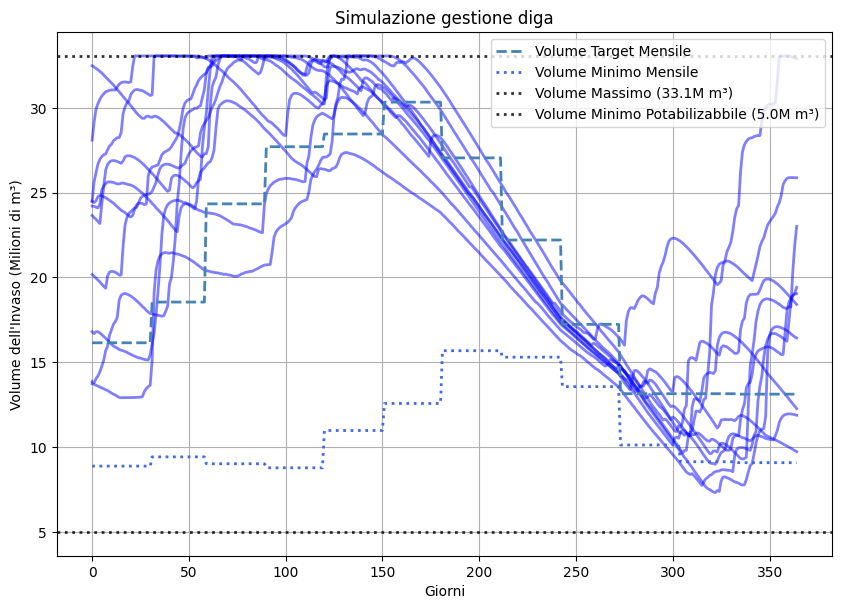


--- RIEPILOGO DELLE METRICHE ---
Errore medio assoluto del volume: 4.09 M m³
Deviazione standard degli errori: 3.45 M m³
Volume minimo raggiunto (media): 10.01 M m³
Volume massimo raggiunto (media): 32.55 M m³
Media dei giorni sotto il minimo dinamico: 7.80
Media dei giorni sopra il massimo: 23.00
Errore medio di previsione: 0.0013 mc/s
Simulazione Monte Carlo completata!


In [ ]:
################## Funzione per calcolare il volume minimo ##################

def calcola_volume_minimo(mese, prelievi_minimi_mensili):

    # Assumiamo che ci sia un volume minimo di sicurezza fisso
    volume_minimo_base = 5_000_000  # 5 milioni di metri cubi

    # Aggiungiamo una riserva basata sul prelievo minimo del mese (esempio di calcolo)
    giorni_riserva = 90  # Riserva per 90 giorni
    volume_riserva = prelievi_minimi_mensili[mese - 1] * 86400 * giorni_riserva

    return volume_minimo_base + volume_riserva


################# Funzione per la simulazione diga con dati reali #################

def simula_gestione_diga_reale(df, indice_inizio, giorni_simulazione, target_mensili, volumi_minimi_necessari, prelievi_minimi_mensili, mese_inizio_dati):

    # Costanti
    MAX_VOLUME = 33062336

    # Assicuriamoci che ci siano abbastanza dati per la simulazione
    if indice_inizio + giorni_simulazione >= len(df):
        giorni_simulazione = len(df) - indice_inizio - 1

    # Prepariamo il dataframe per i risultati
    risultati = []

    # Volume iniziale
    volume_corrente = df.iloc[indice_inizio]['Volume_invaso_(m3)']

    # Variabili per tenere traccia del prelievo e del mese corrente
    prelievo_corrente = None
    mese_precedente = None

    # Nomi dei mesi italiani per reportistica
    mesi = ["Gennaio", "Febbraio", "Marzo", "Aprile", "Maggio", "Giugno",
            "Luglio", "Agosto", "Settembre", "Ottobre", "Novembre", "Dicembre"]

    for i in range(giorni_simulazione):
        # Indice corrente nel dataframe originale
        idx_corrente = indice_inizio + i

        # Otteniamo i dati del giorno corrente
        data_corrente = df.iloc[idx_corrente]['DATA']
        mese_corrente = data_corrente.month
        giorno_corrente = data_corrente.day

        # Verifica se siamo passati a un nuovo mese
        cambio_mese = mese_corrente != mese_precedente if mese_precedente is not None else True

        # Calcolo corretto dell'indice del mese corrente nell'array dei dati
        mese_corrente_idx = (mese_corrente - 1) % 12  # Le liste sono 0-based, il mese è 1-based
        volume_minimo_corrente = volumi_minimi_necessari[mese_corrente_idx]

        # Il mese successivo è 1 mese dopo il corrente
        mese_successivo = (mese_corrente % 12) + 1  # Mese successivo (1-12)
        mese_successivo_idx = (mese_successivo - 1) % 12

        mese_target = (mese_corrente + 1) % 12 + 1  # Se mese_corrente è 11 (dicembre), otteniamo 1 (febbraio)
        mese_target_idx = (mese_target - 1) % 12  # Indice 0-based per il mese target

        # Ottieni i nomi dei mesi per visualizzazione
        mese_corrente_nome = mesi[mese_corrente-1]
        mese_successivo_nome = mesi[mese_successivo-1]
        mese_target_nome = mesi[mese_target-1]

        # Target per i mesi corrente, successivo e futuro
        target_corrente = target_mensili[mese_corrente_idx]
        target_successivo = target_mensili[mese_successivo_idx]
        target_futuro = target_mensili[mese_target_idx]

        # Apporto previsto e reale per il giorno corrente
        apporto_reale_giornaliero = df.iloc[idx_corrente]['Apporto_medio_giornaliero_(mc/s)']
        apporto_previsto_giornaliero = df.iloc[idx_corrente]['Forecast_Apporto_medio_giornaliero_(mc/s)']

        # Calcola il numero di giorni nel mese corrente
        giorni_nel_mese = calendar.monthrange(data_corrente.year, data_corrente.month)[1]

        # Creiamo l'array degli apporti mensili previsti
        forecast_apporti_mensili = np.zeros(12)

        # Per ogni mese, calcoliamo l'apporto mensile previsto
        for mese in range(1, 13):
            dati_mese = df[df['DATA'].dt.month == mese]
            giorni_mese = calendar.monthrange(data_corrente.year, mese)[1]

            if len(dati_mese) > 0:
                # Prende l'ultimo valore disponibile del forecast per il mese
                forecast_base = dati_mese['Forecast_Apporto_medio_giornaliero_(mc/s)'].iloc[-1]
                # Calcola l'apporto mensile
                forecast_apporti_mensili[mese - 1] = forecast_base * 86400 * giorni_mese
            else:
                # Se non ci sono dati per il mese, usa direttamente il valore di forecast giornaliero
                forecast_apporti_mensili[mese - 1] = apporto_previsto_giornaliero * 86400 * giorni_mese

        # MODIFICHE: Incorpora dati reali per i prossimi 7 giorni come previsioni a breve termine
        # Calcola l'apporto mensile per il mese corrente integrando i prossimi 7 giorni come previsioni
        apporto_mensile_totale = 0
        giorni_calcolati = 0

        # 1. Considera i dati reali per i prossimi 7 giorni come se fossero previsioni a breve termine
        for j in range(7):  # Prossimi 7 giorni
            idx_previsione = idx_corrente + j
            # Verifica che l'indice sia valido
            if idx_previsione < len(df) and idx_previsione < indice_inizio + giorni_simulazione:
                # Usa il dato reale come se fosse una previsione a breve termine
                apporto_breve_termine = df.iloc[idx_previsione]['Apporto_medio_giornaliero_(mc/s)']
                apporto_mensile_totale += apporto_breve_termine * 86400  # Conversione in m³/giorno
                giorni_calcolati += 1

        # 2. Per i giorni rimanenti del mese, usa la previsione a lungo termine
        giorni_rimanenti = giorni_nel_mese - giorni_calcolati
        if giorni_rimanenti > 0:
            apporto_mensile_totale += apporto_previsto_giornaliero * 86400 * giorni_rimanenti

        # Aggiorna la previsione di apporto mensile per il mese corrente
        forecast_apporto_mensile = apporto_mensile_totale

        # Calcolo del prelievo ottimale teorico
        prelievo_teorico = calcola_prelievo_giornaliero(
            volume_corrente,
            target_futuro,
            forecast_apporto_mensile,
            giorno_corrente,
            giorni_nel_mese,
            mese_corrente,
            forecast_apporti_mensili,
            mese_inizio_dati,
            prelievi_minimi_mensili
        )

        # Aggiornamento del prelievo:
        # - All'inizio del mese (o primo giorno della simulazione) oppure
        # - A metà mese (quando il giorno corrente è il giorno mediano del mese)
        if prelievo_corrente is None or cambio_mese or giorno_corrente == math.ceil(giorni_nel_mese / 2):
            prelievo_corrente = prelievo_teorico

        prelievo_applicato = prelievo_corrente

        # Simula l'effetto del prelievo e dell'apporto sul volume della diga
        # Usa l'apporto reale per la simulazione, non quello previsto
        delta_giornaliero = (apporto_reale_giornaliero - prelievo_applicato) * 86400  # mc/giorno
        volume_nuovo = volume_corrente + delta_giornaliero

        # Assicuriamoci che il volume non superi il massimo consentito
        if volume_nuovo > MAX_VOLUME:
            volume_nuovo = MAX_VOLUME

        # Registra i risultati
        risultati.append({
            'Data': data_corrente,
            'Volume_Reale': volume_nuovo,
            'Volume_Target_Corrente': target_corrente,
            'Volume_Target_Successivo': target_successivo,
            'Volume_Target_Futuro': target_futuro,
            'Apporto_Previsto': apporto_previsto_giornaliero,
            'Apporto_Reale': apporto_reale_giornaliero,
            'Prelievo_Teorico': prelievo_teorico,
            'Prelievo_Calcolato': prelievo_applicato,
            'Delta_Volume': delta_giornaliero,
            'Error_Forecast': apporto_reale_giornaliero - apporto_previsto_giornaliero,
            'Prelievo_Minimo': prelievi_minimi_mensili[mese_corrente - 1],
            'Volume_Minimo_Dinamico': volume_minimo_corrente,
            'Target_Mese_Corrente': mese_corrente_nome,
            'Target_Mese_Successivo': mese_successivo_nome,
            'Target_Mese_Futuro': mese_target_nome
        })

        # Aggiorna il volume per il prossimo giorno
        volume_corrente = volume_nuovo

        # Aggiorna il mese precedente per il prossimo ciclo
        mese_precedente = mese_corrente

    return pd.DataFrame(risultati)
################## Creazione e plot MonteCarlo test  ##################

def esegui_monte_carlo(df, num_simulazioni, durata_simulazione, target_mensili, volumi_minimi_necessari,
                     prelievi_minimi_mensili, mese_inizio_dati=1):

    # Costanti
    MAX_VOLUME = 33062336

    # Trova gli indici di tutti i giorni di gennaio nel dataset
    gennaio_indices = []
    for i in range(len(df)-1):
       data = df.iloc[i]['DATA']
       if data.month == 1 and data.day == 1:  # Solo il primo giorno di gennaio
        # Verifica che ci siano abbastanza dati per simulare l'intera durata
        if i + durata_simulazione < len(df):
          gennaio_indices.append(i)


    # Verifica se ci sono abbastanza date di gennaio
    if len(gennaio_indices) == 0:
        raise ValueError("Non ci sono date di gennaio nel dataset con sufficiente durata.")

    print(f"Trovati {len(gennaio_indices)} possibili giorni di gennaio nel dataset.")

    # Limita il numero di simulazioni disponibili se necessario
    if len(gennaio_indices) < num_simulazioni:
        print(f"Attenzione: riduzione del numero di simulazioni da {num_simulazioni} a {len(gennaio_indices)} per mancanza di date disponibili.")
        num_simulazioni = len(gennaio_indices)

    # Se ci sono più date di gennaio del numero di simulazioni richieste, seleziona casualmente
    if len(gennaio_indices) > num_simulazioni:
        gennaio_indices = random.sample(gennaio_indices, num_simulazioni)

    # Risultati aggregati
    risultati_simulazioni = []
    performance_metrics = []

    # Esegui le simulazioni
    for sim, start_idx in enumerate(tqdm(gennaio_indices, desc="Esecuzione simulazioni")):
        # Calcola il volume minimo per il mese corrente (gennaio)
        mese_corrente = 1  # Gennaio
        mese_corrente_idx = mese_corrente - 1  # Indice per array 0-based
        volume_minimo_corrente = volumi_minimi_necessari[mese_corrente_idx]

        # Esegui la simulazione
        sim_results = simula_gestione_diga_reale(
            df,
            start_idx,
            durata_simulazione,
            target_mensili,
            volumi_minimi_necessari,
            prelievi_minimi_mensili,
            mese_inizio_dati
        )

        risultati_simulazioni.append(sim_results)

        # Calcolo delle metriche di performance
        mean_abs_volume_error = np.abs(sim_results['Volume_Reale'] - sim_results['Volume_Target_Corrente']).mean()
        std_volume_error = np.abs(sim_results['Volume_Reale'] - sim_results['Volume_Target_Corrente']).std()
        min_volume_reached = sim_results['Volume_Reale'].min()
        max_volume_reached = sim_results['Volume_Reale'].max()

        # Utilizziamo i volumi minimi dinamici per ogni giorno
        volume_under_min = sum(sim_results['Volume_Reale'] < sim_results['Volume_Minimo_Dinamico'])
        volume_over_max = (sim_results['Volume_Reale'] >= MAX_VOLUME).sum()
        mean_forecast_error = sim_results['Error_Forecast'].mean()

        performance_metrics.append({
            'Simulazione': sim,
            'Start_Index': start_idx,
            'Start_Date': df.iloc[start_idx]['DATA'],
            'Mean_Abs_Volume_Error': mean_abs_volume_error,
            'Std_Volume_Error': std_volume_error,
            'Min_Volume_Reached': min_volume_reached,
            'Max_Volume_Reached': max_volume_reached,
            'Days_Under_Min': volume_under_min,
            'Days_Over_Max': volume_over_max,
            'Mean_Forecast_Error': mean_forecast_error,
            'Initial_Volume': df.iloc[start_idx]['Volume_invaso_(m3)'],
            'Initial_Min_Volume': volume_minimo_corrente
        })

    return risultati_simulazioni, pd.DataFrame(performance_metrics)

def visualizza_risultati_monte_carlo(df_metriche, risultati_simulazioni, prelievi_minimi_mensili, volumi_minimi_necessari, num_to_plot=5):

    # Costanti
    MAX_VOLUME = 33062336

    # Figura 3: Plot di alcune simulazioni rappresentative
    plt.figure(figsize=(10, 6.8), dpi=100)

    # Scegli alcune simulazioni random oltre alla migliore e peggiore
    indices_to_plot = list(range(len(risultati_simulazioni)))

    for i, idx in enumerate(indices_to_plot):
        sim_results = risultati_simulazioni[idx]
        days = np.arange(len(sim_results))

        plt.plot(days, sim_results['Volume_Reale'] / 1e6, color='blue', linewidth= 2 , alpha= 0.5, label=None)

    # Plotta il volume target per riferimento (usando i dati della prima simulazione per semplicità)
    plt.plot(days, risultati_simulazioni[0]['Volume_Target_Corrente'] / 1e6,
        label='Volume Target Mensile', color='steelblue', linestyle='--', linewidth=2, alpha=1)

    # Plotta il volume minimo dinamico (della prima simulazione)
    plt.plot(days, risultati_simulazioni[0]['Volume_Minimo_Dinamico'] / 1e6,
        label='Volume Minimo Mensile', color='royalblue', linestyle=':', linewidth=2, alpha=1)

    plt.axhline(MAX_VOLUME / 1e6, color='black', linestyle=':',
               linewidth=2, alpha=0.8, label=f'Volume Massimo ({MAX_VOLUME/1e6:.1f}M m³)')
    plt.axhline(5_000_000 / 1e6, color='black', linestyle=':',
               linewidth=2, alpha=0.8, label=f'Volume Minimo Potabilizabbile ({5_000_000/1e6:.1f}M m³)')
    plt.xlabel("Giorni")
    plt.ylabel("Volume dell'Invaso (Milioni di m³)")
    plt.title("Simulazione gestione diga")
    plt.legend()
    plt.grid()
    plt.show()

    # Riepilogo delle metriche
    print("\n--- RIEPILOGO DELLE METRICHE ---")
    print(f"Errore medio assoluto del volume: {df_metriche['Mean_Abs_Volume_Error'].mean()/1e6:.2f} M m³")
    print(f"Deviazione standard degli errori: {df_metriche['Std_Volume_Error'].mean()/1e6:.2f} M m³")
    print(f"Volume minimo raggiunto (media): {df_metriche['Min_Volume_Reached'].mean()/1e6:.2f} M m³")
    print(f"Volume massimo raggiunto (media): {df_metriche['Max_Volume_Reached'].mean()/1e6:.2f} M m³")
    print(f"Media dei giorni sotto il minimo dinamico: {df_metriche['Days_Under_Min'].mean():.2f}")
    print(f"Media dei giorni sopra il massimo: {df_metriche['Days_Over_Max'].mean():.2f}")
    print(f"Errore medio di previsione: {df_metriche['Mean_Forecast_Error'].mean():.4f} mc/s")

############### Esecuzione MonteCarlo test ###############

def main_monte_carlo_test(df, prelievi_minimi_mensili, volumi_minimi_necessari, target_mensili=None,
                         num_simulazioni=50, durata_simulazione=365, mese_inizio_dati=1):

    print(f"Avvio test Monte Carlo con {num_simulazioni} simulazioni di {durata_simulazione} giorni ciascuna")

    # Se non vengono forniti i target mensili, li calcoliamo dinamicamente dai dati storici
    if target_mensili is None:
        target_mensili = np.zeros(12)

        # Usiamo la media dei volumi storici per mese come target
        for mese in range(1, 13):
            target_mese = df[df['DATA'].dt.month == mese]['Volume_invaso_(m3)'].mean()
            target_mensili[mese-1] = target_mese

        print("Target mensili calcolati dai dati storici:")
        mesi = ["Gen", "Feb", "Mar", "Apr", "Mag", "Giu", "Lug", "Ago", "Set", "Ott", "Nov", "Dic"]
        for i, mese in enumerate(mesi):
            print(f"{mese}: {target_mensili[i]/1e6:.2f} M m³")
    else:
        print("Utilizzo target mensili forniti esternamente")

    # Esegui il test Monte Carlo
    risultati_simulazioni, df_metriche = esegui_monte_carlo(
        df,
        num_simulazioni,
        durata_simulazione,
        target_mensili,
        volumi_minimi_necessari,
        prelievi_minimi_mensili,
        mese_inizio_dati
    )

    # Visualizza i risultati
    visualizza_risultati_monte_carlo(df_metriche, risultati_simulazioni, prelievi_minimi_mensili, volumi_minimi_necessari)

    return risultati_simulazioni, df_metriche

# Esempio di utilizzo
def run_monte_carlo_example():
    # Assumiamo che df e volumi_target_fattibili siano disponibili globalmente
    # Questi valori dovrebbero essere definiti altrove nel codice completo

    # Definizione dei prelievi minimi mensili (mc/s)
    # Valori per ogni mese (Gen, Feb, Mar, Apr, Mag, Giu, Lug, Ago, Set, Ott, Nov, Dic)
    prelievi_minimi_mensili = [0.499, 0.569, 0.517, 0.486, 0.769, 0.974, 1.374, 1.325, 1.1015, 0.659, 0.532, 0.525]

    # Se i volumi minimi necessari non sono stati precedentemente calcolati
    # li calcoliamo qui (questo è un esempio, in realtà dovrebbero essere passati dall'algoritmo dei target)
    volumi_minimi_necessari = [calcola_volume_minimo(m+1, prelievi_minimi_mensili) for m in range(12)]

    # Esegui il test Monte Carlo
    # Se volumi_target_fattibili è disponibile globalmente, lo possiamo usare qui
    try:
        risultati, metriche = main_monte_carlo_test(
            df,
            prelievi_minimi_mensili,
            volumi_minimi_necessari,
            target_mensili=volumi_target_fattibili,  # Passa i target se disponibili
            num_simulazioni=100,
            durata_simulazione=365
        )
    except NameError:
        # Se volumi_target_fattibili non è disponibile, lasciamo che il test calcoli i target dai dati storici
        risultati, metriche = main_monte_carlo_test(
            df,
            prelievi_minimi_mensili,
            volumi_minimi_necessari,
            num_simulazioni=100,
            durata_simulazione=365
        )

    return risultati, metriche

# Se questo script viene eseguito direttamente
if __name__ == "__main__":
    # Esegui il test Monte Carlo
    risultati_mc, metriche_mc = run_monte_carlo_example()
    print("Simulazione Monte Carlo completata!")


ANALISI POST-SIMULAZIONE MONTE CARLO

Avvio analisi del caso migliore...
Data di inizio registrata: 2024-01-01 08:00:00
RIEPILOGO DELLE METRICHE DEL CASO MIGLIORE (Simulazione #9)
Data inizio: 2024-01-01 08:00:00
Errore medio assoluto: 5.37 M m³
Errore medio di previsione: 0.3288 mc/s
Giorni sotto il minimo: 0
Giorni sotto il minimo: 0
Giorni sopra il massimo: 26
Volume minimo raggiunto: 16.01 M m³
Volume massimo raggiunto: 33.06 M m³


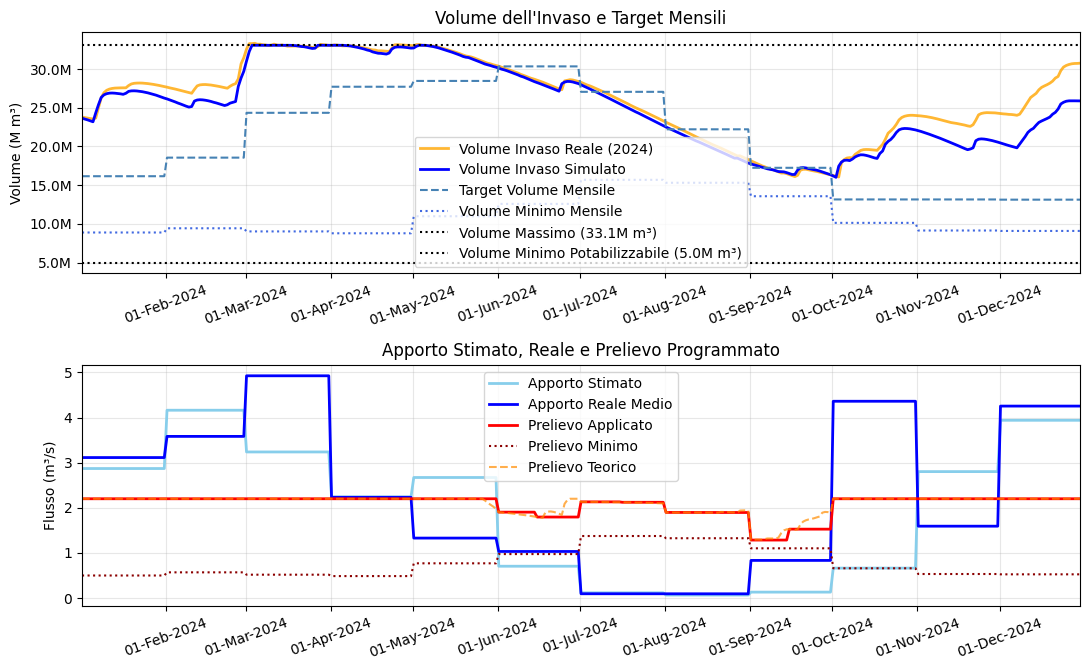


Avvio analisi del caso peggiore...
Data di inizio registrata: 2017-01-01 08:00:00
RIEPILOGO DELLE METRICHE DEL CASO PEGGIORE (Simulazione #2)
Data inizio: 2017-01-01 08:00:00
Errore medio assoluto: 3.33 M m³
Errore medio di previsione: -0.2847 mc/s
Giorni sotto il minimo: 37
Giorni sopra il massimo: 0
Volume minimo raggiunto: 7.74 M m³
Volume massimo raggiunto: 30.41 M m³


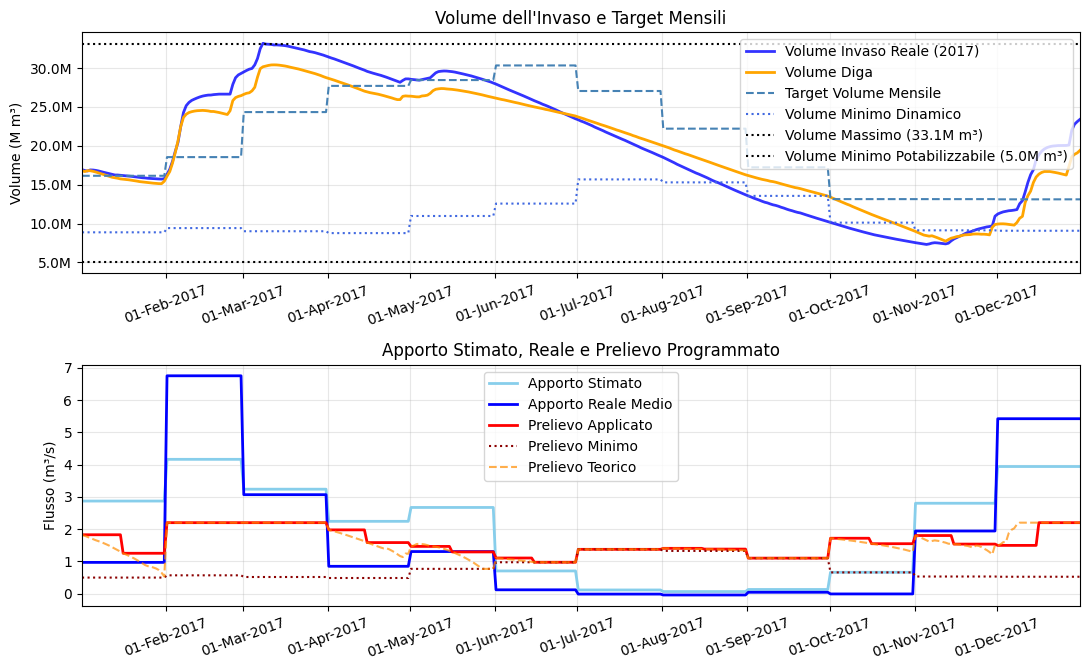


Analisi completata!


In [ ]:
def format_date_axis(ax):

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Filtra i dati osservati per l'anno 2024
df_2024 = df[df['ANNO'] == '2024']
df_2017 = df[df['ANNO'] == '2017']

def analyze_best_case_simplified(risultati_simulazioni, df_metriche):

    # Costanti
    MAX_VOLUME = 33062336

    # Identifica l'indice della simulazione migliore (errore più basso)
    best_sim_idx = df_metriche[df_metriche['Start_Date'] == '2024-01-01 08:00:00'].index[0]
    best_sim_data = risultati_simulazioni[best_sim_idx]
    best_sim_start_date = df_metriche.iloc[best_sim_idx]['Start_Date']
    best_sim_end_date = best_sim_data['Data'].iloc[-1]

    print("Data di inizio registrata:", best_sim_start_date)

    # Calcola l'apporto reale medio mensile
    best_sim_data['Mese'] = best_sim_data['Data'].dt.to_period('M')
    apporto_mensile = best_sim_data.groupby('Mese')['Apporto_Reale'].mean().reset_index()
    best_sim_data = best_sim_data.merge(apporto_mensile, on='Mese', suffixes=('', '_Mensile'))

    # Stampa riepilogo delle metriche
    print("=" * 80)
    print(f"RIEPILOGO DELLE METRICHE DEL CASO MIGLIORE (Simulazione #{best_sim_idx})")
    print("=" * 80)
    print(f"Data inizio: {best_sim_start_date}")
    print(f"Errore medio assoluto: {df_metriche.iloc[best_sim_idx]['Mean_Abs_Volume_Error']/1e6:.2f} M m³")
    print(f"Errore medio di previsione: {df_metriche.iloc[best_sim_idx]['Mean_Forecast_Error']:.4f} mc/s")
    print(f"Giorni sotto il minimo: {df_metriche.iloc[best_sim_idx]['Days_Under_Min']}")
    print(f"Giorni sotto il minimo: {df_metriche.iloc[best_sim_idx]['Days_Under_Min']}")
    print(f"Giorni sopra il massimo: {df_metriche.iloc[best_sim_idx]['Days_Over_Max']}")
    print(f"Volume minimo raggiunto: {df_metriche.iloc[best_sim_idx]['Min_Volume_Reached']/1e6:.2f} M m³")
    print(f"Volume massimo raggiunto: {df_metriche.iloc[best_sim_idx]['Max_Volume_Reached']/1e6:.2f} M m³")

    # Funzione per formattare l’asse Y in milioni
    def millions(x, pos):
       return f'{x:.1f}M'

    # Crea una figura con 2 subplot
    fig, axs = plt.subplots(2, 1, figsize=(11,6.8), dpi=100, sharex=True)
    axs[0].tick_params(labelbottom=True)

    # 1. Plot del volume vs target
    axs[0].plot(df_2024['DATA'], df_2024['Volume_invaso_(m3)'] / 1e6,
            label='Volume Invaso Reale (2024)', color='orange', linewidth=2, alpha=0.8)
    axs[0].plot(best_sim_data['Data'], best_sim_data['Volume_Reale']/1e6,
                label='Volume Invaso Simulato', color='blue', linewidth=2)
    axs[0].plot(best_sim_data['Data'], best_sim_data['Volume_Target_Corrente']/1e6,
                label='Target Volume Mensile', color='steelblue', linestyle='--')
    axs[0].plot(best_sim_data['Data'], best_sim_data['Volume_Minimo_Dinamico']/1e6,
                label='Volume Minimo Mensile', color='royalblue', linestyle=':')
    axs[0].axhline(MAX_VOLUME/1e6, color='black', linestyle=':',
                   linewidth=1.5, label=f'Volume Massimo ({MAX_VOLUME / 1e6:.1f}M m³)')
    axs[0].axhline(5_000_000/1e6, color='black', linestyle=':',
                   linewidth=1.5, label=f'Volume Minimo Potabilizzabile (5.0M m³)')
    axs[0].set_title('Volume dell\'Invaso e Target Mensili')
    axs[0].tick_params(axis='x', rotation=20)
    axs[0].set_ylabel('Volume (M m³)')
    axs[0].ticklabel_format(style='plain', axis='y')
    axs[0].legend(loc='best')
    axs[0].grid(True, alpha=0.3)

    # Formatta y-axis in milioni
    axs[0].yaxis.set_major_formatter(FuncFormatter(millions))

    # Formatta asse x
    date_format = mdates.DateFormatter('%d-%b-%Y')
    axs[0].xaxis.set_major_formatter(date_format)
    axs[0].xaxis.set_major_locator(mdates.MonthLocator())

    # 2. Plot di apporto e prelievo
    axs[1].plot(best_sim_data['Data'], best_sim_data['Apporto_Previsto'],
                label='Apporto Stimato', color='skyblue', linewidth=2)
    axs[1].plot(best_sim_data['Data'], best_sim_data['Apporto_Reale_Mensile'],
                label='Apporto Reale Medio', color='blue', linewidth=2)
    axs[1].plot(best_sim_data['Data'], best_sim_data['Prelievo_Calcolato'],
                label='Prelievo Applicato', color='red', linewidth=2)
    axs[1].plot(best_sim_data['Data'], best_sim_data['Prelievo_Minimo'], label='Prelievo Minimo',
               color='darkred', linestyle=':')
    axs[1].plot(best_sim_data['Data'], best_sim_data['Prelievo_Teorico'],
                label='Prelievo Teorico', color='darkorange', linestyle='--', alpha=0.7)

    axs[1].set_title('Apporto Stimato, Reale e Prelievo Programmato')
    axs[1].tick_params(axis='x', rotation=20)
    axs[1].set_ylabel('Flusso (m³/s)')
    axs[1].legend(loc='best')
    axs[1].grid(True, alpha=0.3)

    axs[1].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_locator(mdates.MonthLocator())

    # Limiti dell’asse x
    axs[1].set_xlim([best_sim_start_date, best_sim_end_date])

    # Spaziatura layout
    plt.tight_layout()
    plt.show()

def analyze_worst_case_simplified(risultati_simulazioni, df_metriche):

    # Costanti
    MAX_VOLUME = 33062336

    # Identifica l'indice della simulazione peggiore
    worst_sim_idx = df_metriche[df_metriche['Start_Date'] == '2017-01-01 08:00:00'].index[0]
    worst_sim_data = risultati_simulazioni[worst_sim_idx]
    worst_sim_start_date = df_metriche.iloc[worst_sim_idx]['Start_Date']
    worst_sim_end_date = worst_sim_data['Data'].iloc[-1]

    print("Data di inizio registrata:", worst_sim_start_date)

    # Calcola l'apporto reale medio mensile
    worst_sim_data['Mese'] = worst_sim_data['Data'].dt.to_period('M')
    apporto_mensile = worst_sim_data.groupby('Mese')['Apporto_Reale'].mean().reset_index()
    worst_sim_data = worst_sim_data.merge(apporto_mensile, on='Mese', suffixes=('', '_Mensile'))

    # Stampa riepilogo delle metriche
    print("=" * 80)
    print(f"RIEPILOGO DELLE METRICHE DEL CASO PEGGIORE (Simulazione #{worst_sim_idx})")
    print("=" * 80)
    print(f"Data inizio: {worst_sim_start_date}")
    print(f"Errore medio assoluto: {df_metriche.iloc[worst_sim_idx]['Mean_Abs_Volume_Error']/1e6:.2f} M m³")
    print(f"Errore medio di previsione: {df_metriche.iloc[worst_sim_idx]['Mean_Forecast_Error']:.4f} mc/s")
    print(f"Giorni sotto il minimo: {df_metriche.iloc[worst_sim_idx]['Days_Under_Min']}")
    print(f"Giorni sopra il massimo: {df_metriche.iloc[worst_sim_idx]['Days_Over_Max']}")
    print(f"Volume minimo raggiunto: {df_metriche.iloc[worst_sim_idx]['Min_Volume_Reached']/1e6:.2f} M m³")
    print(f"Volume massimo raggiunto: {df_metriche.iloc[worst_sim_idx]['Max_Volume_Reached']/1e6:.2f} M m³")

    # Funzione per formattare l’asse Y in milioni
    def millions(x, pos):
       return f'{x:.1f}M'

    # Crea una figura con 2 subplot
    fig, axs = plt.subplots(2, 1, figsize=(11,6.8), dpi=100, sharex=True)
    axs[0].tick_params(labelbottom=True)

    # 1. Plot del volume vs target
    axs[0].plot(df_2017['DATA'], df_2017['Volume_invaso_(m3)'] / 1e6,
            label='Volume Invaso Reale (2017)', color='blue', linewidth=2, alpha=0.8)
    axs[0].plot(worst_sim_data['Data'], worst_sim_data['Volume_Reale']/1e6,
                label='Volume Diga', color='orange', linewidth=2)
    axs[0].plot(worst_sim_data['Data'], worst_sim_data['Volume_Target_Corrente']/1e6,
                label='Target Volume Mensile', color='steelblue', linestyle='--')
    axs[0].plot(worst_sim_data['Data'], worst_sim_data['Volume_Minimo_Dinamico']/1e6,
                label='Volume Minimo Dinamico', color='royalblue', linestyle=':')
    axs[0].axhline(MAX_VOLUME/1e6, color='black', linestyle=':',
                   linewidth=1.5, label=f'Volume Massimo ({MAX_VOLUME / 1e6:.1f}M m³)')
    axs[0].axhline(5_000_000/1e6, color='black', linestyle=':',
                   linewidth=1.5, label=f'Volume Minimo Potabilizzabile (5.0M m³)')
    axs[0].set_title('Volume dell\'Invaso e Target Mensili')
    axs[0].tick_params(axis='x', rotation=20)
    axs[0].set_ylabel('Volume (M m³)')
    axs[0].ticklabel_format(style='plain', axis='y')
    axs[0].legend(loc='best')
    axs[0].grid(True, alpha=0.3)

    # Formatta y-axis in milioni
    axs[0].yaxis.set_major_formatter(FuncFormatter(millions))

    # Formatta asse x
    date_format = mdates.DateFormatter('%d-%b-%Y')
    axs[0].xaxis.set_major_formatter(date_format)
    axs[0].xaxis.set_major_locator(mdates.MonthLocator())

    # 2. Plot di apporto e prelievo
    axs[1].plot(worst_sim_data['Data'], worst_sim_data['Apporto_Previsto'],
                label='Apporto Stimato', color='skyblue', linewidth=2)
    axs[1].plot(worst_sim_data['Data'], worst_sim_data['Apporto_Reale_Mensile'],
                label='Apporto Reale Medio', color='blue', linewidth=2)
    axs[1].plot(worst_sim_data['Data'], worst_sim_data['Prelievo_Calcolato'],
                label='Prelievo Applicato', color='red', linewidth=2)
    axs[1].plot(worst_sim_data['Data'], worst_sim_data['Prelievo_Minimo'], label='Prelievo Minimo',
               color='darkred', linestyle=':')
    axs[1].plot(worst_sim_data['Data'], worst_sim_data['Prelievo_Teorico'],
                label='Prelievo Teorico', color='darkorange', linestyle='--', alpha=0.7)

    axs[1].set_title('Apporto Stimato, Reale e Prelievo Programmato')
    axs[1].tick_params(axis='x', rotation=20)
    axs[1].set_ylabel('Flusso (m³/s)')
    axs[1].legend(loc='best')
    axs[1].grid(True, alpha=0.3)

    axs[1].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_locator(mdates.MonthLocator())

    # Limiti dell’asse x
    axs[1].set_xlim([worst_sim_start_date, worst_sim_end_date])

    # Spaziatura layout
    plt.tight_layout()
    plt.show()

# Questa è la parte principale da aggiungere alla fine del tuo codice di analisi best/worst
# Inserisci questo blocco alla fine dello script per utilizzarlo in una cella separata di Colab

# =============== BLOCCO DA ESEGUIRE IN UNA CELLA SEPARATA DI COLAB =================

# Inserisci questa parte del codice in una cella separata dopo aver eseguito il Monte Carlo
def run_analysis(risultati_simulazioni=None, df_metriche=None, target_mensili=None, volumi_minimi_necessari=None):


    # Verifica se i dati di input sono disponibili
    if risultati_simulazioni is None or df_metriche is None:
        # Tenta di utilizzare variabili globali se non vengono forniti parametri
        try:
            # Verifica se esistono le variabili globali 'risultati' e 'metriche'
            global risultati, metriche
            risultati_simulazioni = risultati
            df_metriche = metriche
            print("Utilizzando le variabili 'risultati' e 'metriche' disponibili nell'ambiente globale.")
        except NameError:
            return

    print("\n" + "="*80)
    print("ANALISI POST-SIMULAZIONE MONTE CARLO")
    print("="*80)

    # Analisi del caso migliore
    print("\nAvvio analisi del caso migliore...")
    analyze_best_case_simplified(risultati_simulazioni, df_metriche)

    # Analisi del caso peggiore
    print("\nAvvio analisi del caso peggiore...")
    analyze_worst_case_simplified(risultati_simulazioni, df_metriche)

    print("\nAnalisi completata!")

# Se questo script viene eseguito direttamente
if __name__ == "__main__":
    # Esegui l'analisi con le variabili globali se disponibili
    run_analysis()

run_analysis(risultati_mc, metriche_mc)


# Simulazione 10 anni

Avvio test Monte Carlo con 1 simulazioni di 3652 giorni ciascuna
Utilizzo target mensili forniti esternamente
Trovati 1 possibili giorni di gennaio nel dataset.


Esecuzione simulazioni: 100%|██████████| 1/1 [00:43<00:00, 43.06s/it]


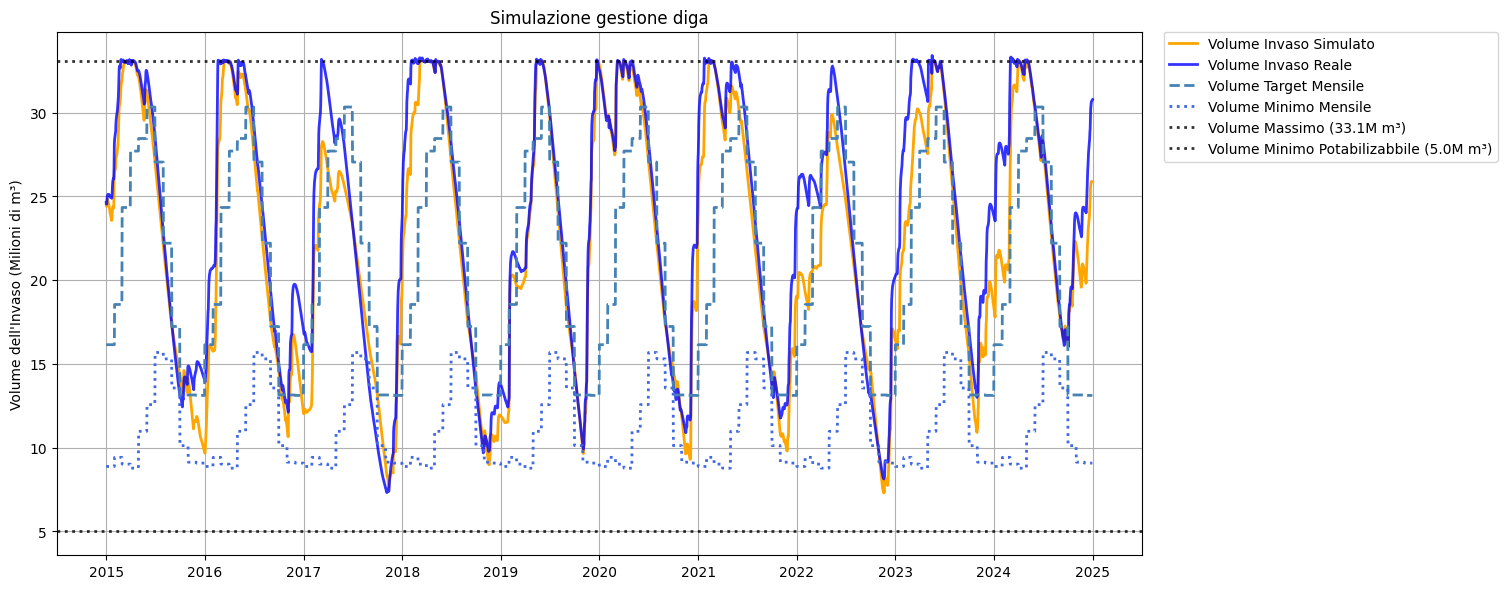


--- RIEPILOGO DELLE METRICHE ---
Errore medio assoluto del volume: 3.77 M m³
Deviazione standard degli errori: 3.27 M m³
Volume minimo raggiunto (media): 7.30 M m³
Volume massimo raggiunto (media): 33.06 M m³
Media dei giorni sotto il minimo dinamico: 81.00
Media dei giorni sopra il massimo: 153.00
Errore medio di previsione: 0.0010 mc/s

--- METRICHE SUI DATI REALI ---
Errore medio assoluto del volume: 4.51 M m³
Deviazione standard degli errori: 4.11 M m³
Volume minimo raggiunto: 7.32 M m³
Volume massimo raggiunto: 33.41 M m³
Giorni sotto il minimo dinamico: 132
Giorni sopra il massimo: 235
Errore medio di previsione: non disponibile nei dati reali

--- CONFRONTO SIMULAZIONI VS DATI REALI ---
Mean_Abs_Volume_Error: Simulazioni = 3.77 M m³, Reali = 4.51 M m³
Std_Volume_Error: Simulazioni = 3.27 M m³, Reali = 4.11 M m³
Min_Volume_Reached: Simulazioni = 7.30 M m³, Reali = 7.32 M m³
Max_Volume_Reached: Simulazioni = 33.06 M m³, Reali = 33.41 M m³
Days_Under_Min: Simulazioni = 81.00, Real

In [ ]:
################## Creazione e plot MonteCarlo test  ##################

def esegui_monte_carlo(df, num_simulazioni, durata_simulazione, target_mensili, volumi_minimi_necessari,
                     prelievi_minimi_mensili, mese_inizio_dati=1):

    # Costanti
    MAX_VOLUME = 33062336

    # Trova gli indici di tutti i giorni di gennaio nel dataset
    gennaio_indices = []
    for i in range(len(df)-1):
       data = df.iloc[i]['DATA']
       if data.month == 1 and data.day == 1 and data.year == 2015:  # Solo il primo giorno di gennaio
        # Verifica che ci siano abbastanza dati per simulare l'intera durata
        if i + durata_simulazione < len(df):
          gennaio_indices.append(i)


    # Verifica se ci sono abbastanza date di gennaio
    if len(gennaio_indices) == 0:
        raise ValueError("Non ci sono date di gennaio nel dataset con sufficiente durata.")

    print(f"Trovati {len(gennaio_indices)} possibili giorni di gennaio nel dataset.")

    # Limita il numero di simulazioni disponibili se necessario
    if len(gennaio_indices) < num_simulazioni:
        print(f"Attenzione: riduzione del numero di simulazioni da {num_simulazioni} a {len(gennaio_indices)} per mancanza di date disponibili.")
        num_simulazioni = len(gennaio_indices)

    # Se ci sono più date di gennaio del numero di simulazioni richieste, seleziona casualmente
    if len(gennaio_indices) > num_simulazioni:
        gennaio_indices = random.sample(gennaio_indices, num_simulazioni)

    # Risultati aggregati
    risultati_simulazioni = []
    performance_metrics = []

    # Esegui le simulazioni
    for sim, start_idx in enumerate(tqdm(gennaio_indices, desc="Esecuzione simulazioni")):
        # Calcola il volume minimo per il mese corrente (gennaio)
        mese_corrente = 1  # Gennaio
        mese_corrente_idx = mese_corrente - 1  # Indice per array 0-based
        volume_minimo_corrente = volumi_minimi_necessari[mese_corrente_idx]

        # Esegui la simulazione
        sim_results = simula_gestione_diga_reale(
            df,
            start_idx,
            durata_simulazione,
            target_mensili,
            volumi_minimi_necessari,
            prelievi_minimi_mensili,
            mese_inizio_dati
        )

        risultati_simulazioni.append(sim_results)

        # Calcolo delle metriche di performance
        mean_abs_volume_error = np.abs(sim_results['Volume_Reale'] - sim_results['Volume_Target_Corrente']).mean()
        std_volume_error = np.abs(sim_results['Volume_Reale'] - sim_results['Volume_Target_Corrente']).std()
        min_volume_reached = sim_results['Volume_Reale'].min()
        max_volume_reached = sim_results['Volume_Reale'].max()

        # Utilizziamo i volumi minimi dinamici per ogni giorno
        volume_under_min = sum(sim_results['Volume_Reale'] < sim_results['Volume_Minimo_Dinamico'])
        volume_over_max = (sim_results['Volume_Reale'] >= MAX_VOLUME).sum()
        mean_forecast_error = sim_results['Error_Forecast'].mean()

        performance_metrics.append({
            'Simulazione': sim,
            'Start_Index': start_idx,
            'Start_Date': df.iloc[start_idx]['DATA'],
            'Mean_Abs_Volume_Error': mean_abs_volume_error,
            'Std_Volume_Error': std_volume_error,
            'Min_Volume_Reached': min_volume_reached,
            'Max_Volume_Reached': max_volume_reached,
            'Days_Under_Min': volume_under_min,
            'Days_Over_Max': volume_over_max,
            'Mean_Forecast_Error': mean_forecast_error,
            'Initial_Volume': df.iloc[start_idx]['Volume_invaso_(m3)'],
            'Initial_Min_Volume': volume_minimo_corrente
        })

    return risultati_simulazioni, pd.DataFrame(performance_metrics)

def visualizza_risultati_monte_carlo(df_metriche, risultati_simulazioni, prelievi_minimi_mensili, volumi_minimi_necessari, num_to_plot=5):

    # Costanti
    MAX_VOLUME = 33062336
    sim_idx = df_metriche[df_metriche['Start_Date'] == '2015-01-01 08:00:00'].index[0]
    sim_data = risultati_simulazioni[sim_idx]

    # Figura 3: Plot di alcune simulazioni rappresentative
    plt.figure(figsize=(14, 6.8), dpi=100)

    plt.plot(sim_data['Data'], sim_data['Volume_Reale'] / 1e6,
             label='Volume Invaso Simulato', color='orange', linewidth= 2)
    plt.plot(df['DATA'], df['Volume_invaso_(m3)'] / 1e6,
            label='Volume Invaso Reale', color='blue', linewidth=2, alpha=0.8)
    # Plotta il volume target per riferimento (usando i dati della prima simulazione per semplicità)
    plt.plot(sim_data['Data'], risultati_simulazioni[0]['Volume_Target_Corrente'] / 1e6,
        label='Volume Target Mensile', color='steelblue', linestyle='--', linewidth=2, alpha=1)

    # Plotta il volume minimo dinamico (della prima simulazione)
    plt.plot(sim_data['Data'], risultati_simulazioni[0]['Volume_Minimo_Dinamico'] / 1e6,
        label='Volume Minimo Mensile', color='royalblue', linestyle=':', linewidth=2, alpha=1)

    plt.axhline(MAX_VOLUME / 1e6, color='black', linestyle=':',
               linewidth=2, alpha=0.8, label=f'Volume Massimo ({MAX_VOLUME/1e6:.1f}M m³)')
    plt.axhline(5_000_000 / 1e6, color='black', linestyle=':',
               linewidth=2, alpha=0.8, label=f'Volume Minimo Potabilizabbile ({5_000_000/1e6:.1f}M m³)')
    plt.ylabel("Volume dell'Invaso (Milioni di m³)")
    plt.title("Simulazione gestione diga")
    # Legenda completamente fuori dal grafico, in alto a destra
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)
    plt.grid()
    plt.show()

    # Riepilogo delle metriche
    print("\n--- RIEPILOGO DELLE METRICHE ---")
    print(f"Errore medio assoluto del volume: {df_metriche['Mean_Abs_Volume_Error'].mean()/1e6:.2f} M m³")
    print(f"Deviazione standard degli errori: {df_metriche['Std_Volume_Error'].mean()/1e6:.2f} M m³")
    print(f"Volume minimo raggiunto (media): {df_metriche['Min_Volume_Reached'].mean()/1e6:.2f} M m³")
    print(f"Volume massimo raggiunto (media): {df_metriche['Max_Volume_Reached'].mean()/1e6:.2f} M m³")
    print(f"Media dei giorni sotto il minimo dinamico: {df_metriche['Days_Under_Min'].mean():.2f}")
    print(f"Media dei giorni sopra il massimo: {df_metriche['Days_Over_Max'].mean():.2f}")
    print(f"Errore medio di previsione: {df_metriche['Mean_Forecast_Error'].mean():.4f} mc/s")

############### Esecuzione MonteCarlo test ###############

def main_monte_carlo_test(df, prelievi_minimi_mensili, volumi_minimi_necessari, target_mensili=None,
                         num_simulazioni=50, durata_simulazione=3652, mese_inizio_dati=1):

    print(f"Avvio test Monte Carlo con {num_simulazioni} simulazioni di {durata_simulazione} giorni ciascuna")

    # Se non vengono forniti i target mensili, li calcoliamo dinamicamente dai dati storici
    if target_mensili is None:
        target_mensili = np.zeros(12)

        # Usiamo la media dei volumi storici per mese come target
        for mese in range(1, 13):
            target_mese = df[df['DATA'].dt.month == mese]['Volume_invaso_(m3)'].mean()
            target_mensili[mese-1] = target_mese

        print("Target mensili calcolati dai dati storici:")
        mesi = ["Gen", "Feb", "Mar", "Apr", "Mag", "Giu", "Lug", "Ago", "Set", "Ott", "Nov", "Dic"]
        for i, mese in enumerate(mesi):
            print(f"{mese}: {target_mensili[i]/1e6:.2f} M m³")
    else:
        print("Utilizzo target mensili forniti esternamente")

    # Esegui il test Monte Carlo
    risultati_simulazioni, df_metriche = esegui_monte_carlo(
        df,
        num_simulazioni,
        durata_simulazione,
        target_mensili,
        volumi_minimi_necessari,
        prelievi_minimi_mensili,
        mese_inizio_dati
    )

    # Visualizza i risultati
    visualizza_risultati_monte_carlo(df_metriche, risultati_simulazioni, prelievi_minimi_mensili, volumi_minimi_necessari)

    return risultati_simulazioni, df_metriche





def calcola_metriche_dati_reali(df, target_mensili, volumi_minimi_necessari, durata_analisi=None):

    # Costanti
    MAX_VOLUME = 33062336

    # Limita la durata dell'analisi se specificato
    if durata_analisi is not None and durata_analisi < len(df):
        df_analisi = df.iloc[:durata_analisi].copy()
    else:
        df_analisi = df.copy()

    # Calcolo del volume target dinamico per ogni giorno
    df_analisi['Volume_Target_Corrente'] = df_analisi['DATA'].apply(
        lambda x: target_mensili[x.month - 1]
    )

    # Calcolo del volume minimo dinamico per ogni giorno
    df_analisi['Volume_Minimo_Dinamico'] = df_analisi['DATA'].apply(
        lambda x: volumi_minimi_necessari[x.month - 1]
    )

    # Calcolo delle metriche
    mean_abs_volume_error = np.abs(df_analisi['Volume_invaso_(m3)'] - df_analisi['Volume_Target_Corrente']).mean()
    std_volume_error = np.abs(df_analisi['Volume_invaso_(m3)'] - df_analisi['Volume_Target_Corrente']).std()
    min_volume_reached = df_analisi['Volume_invaso_(m3)'].min()
    max_volume_reached = df_analisi['Volume_invaso_(m3)'].max()

    # Volume sotto il minimo dinamico e sopra il massimo
    volume_under_min = (df_analisi['Volume_invaso_(m3)'] < df_analisi['Volume_Minimo_Dinamico']).sum()
    volume_over_max = (df_analisi['Volume_invaso_(m3)'] >= MAX_VOLUME).sum()

    # Errore medio di previsione (se disponibile nel dataset reale)
    mean_forecast_error = df_analisi.get('Error_Forecast', pd.Series([0])).mean()

    # Creazione del DataFrame con le metriche
    metriche_reali = pd.DataFrame({
        'Simulazione': ['Dati Reali'],
        'Mean_Abs_Volume_Error': [mean_abs_volume_error],
        'Std_Volume_Error': [std_volume_error],
        'Min_Volume_Reached': [min_volume_reached],
        'Max_Volume_Reached': [max_volume_reached],
        'Days_Under_Min': [volume_under_min],
        'Days_Over_Max': [volume_over_max],
        'Mean_Forecast_Error': [mean_forecast_error]
    })

    print("\n--- METRICHE SUI DATI REALI ---")
    print(f"Errore medio assoluto del volume: {mean_abs_volume_error/1e6:.2f} M m³")
    print(f"Deviazione standard degli errori: {std_volume_error/1e6:.2f} M m³")
    print(f"Volume minimo raggiunto: {min_volume_reached/1e6:.2f} M m³")
    print(f"Volume massimo raggiunto: {max_volume_reached/1e6:.2f} M m³")
    print(f"Giorni sotto il minimo dinamico: {volume_under_min}")
    print(f"Giorni sopra il massimo: {volume_over_max}")
    if 'Error_Forecast' in df_analisi.columns:
        print(f"Errore medio di previsione: {mean_forecast_error:.4f} mc/s")
    else:
        print("Errore medio di previsione: non disponibile nei dati reali")

    return metriche_reali




def confronta_metriche(df_metriche_simulazioni, df_metriche_reali):

    # Calcola medie delle simulazioni
    medie_simulazioni = pd.DataFrame({
        'Simulazione': ['Media Simulazioni'],
        'Mean_Abs_Volume_Error': [df_metriche_simulazioni['Mean_Abs_Volume_Error'].mean()],
        'Std_Volume_Error': [df_metriche_simulazioni['Std_Volume_Error'].mean()],
        'Min_Volume_Reached': [df_metriche_simulazioni['Min_Volume_Reached'].mean()],
        'Max_Volume_Reached': [df_metriche_simulazioni['Max_Volume_Reached'].mean()],
        'Days_Under_Min': [df_metriche_simulazioni['Days_Under_Min'].mean()],
        'Days_Over_Max': [df_metriche_simulazioni['Days_Over_Max'].mean()],
        'Mean_Forecast_Error': [df_metriche_simulazioni['Mean_Forecast_Error'].mean()]
    })

    # Combina le metriche per il confronto
    df_confronto = pd.concat([medie_simulazioni, df_metriche_reali], ignore_index=True)

    # Visualizza confronto
    print("\n--- CONFRONTO SIMULAZIONI VS DATI REALI ---")
    for metrica in ['Mean_Abs_Volume_Error', 'Std_Volume_Error', 'Min_Volume_Reached',
                    'Max_Volume_Reached', 'Days_Under_Min', 'Days_Over_Max']:

        if 'Volume' in metrica and metrica != 'Days_Under_Min' and metrica != 'Days_Over_Max':
            # Formatta i volumi in milioni di m³
            print(f"{metrica}: Simulazioni = {medie_simulazioni[metrica].values[0]/1e6:.2f} M m³, "
                  f"Reali = {df_metriche_reali[metrica].values[0]/1e6:.2f} M m³")
        else:
            print(f"{metrica}: Simulazioni = {medie_simulazioni[metrica].values[0]:.2f}, "
                  f"Reali = {df_metriche_reali[metrica].values[0]:.2f}")

    return df_confronto

def run_monte_carlo_example():
    # Valori per ogni mese (Gen, Feb, Mar, Apr, Mag, Giu, Lug, Ago, Set, Ott, Nov, Dic)
    prelievi_minimi_mensili = [0.499, 0.569, 0.517, 0.486, 0.769, 0.974, 1.374, 1.325, 1.1015, 0.659, 0.532, 0.525]

    # Se i volumi minimi necessari non sono stati precedentemente calcolati
    # li calcoliamo qui (questo è un esempio, in realtà dovrebbero essere passati dall'algoritmo dei target)
    volumi_minimi_necessari = [calcola_volume_minimo(m+1, prelievi_minimi_mensili) for m in range(12)]

    # Esegui il test Monte Carlo
    try:
        risultati, metriche = main_monte_carlo_test(
            df,
            prelievi_minimi_mensili,
            volumi_minimi_necessari,
            target_mensili=volumi_target_fattibili,  # Passa i target se disponibili
            num_simulazioni=1,
            durata_simulazione=3652
        )
    except NameError:
        # Se volumi_target_fattibili non è disponibile, lasciamo che il test calcoli i target dai dati storici
        risultati, metriche = main_monte_carlo_test(
            df,
            prelievi_minimi_mensili,
            volumi_minimi_necessari,
            num_simulazioni=1,
            durata_simulazione=3652
        )

    # Calcola le metriche sui dati reali per confronto
    try:
        # Usa gli stessi target delle simulazioni se disponibili
        target_mensili = volumi_target_fattibili
    except NameError:
        # Calcola i target dai dati storici come fatto nella funzione main_monte_carlo_test
        target_mensili = np.zeros(12)
        for mese in range(1, 13):
            target_mensili[mese-1] = df[df['DATA'].dt.month == mese]['Volume_invaso_(m3)'].mean()

    # Calcola le metriche sui dati reali usando la stessa durata della simulazione
    metriche_reali = calcola_metriche_dati_reali(
        df,
        target_mensili,
        volumi_minimi_necessari,
        durata_analisi=3652  # Usa la stessa durata delle simulazioni
    )

    # Confronta le metriche delle simulazioni con quelle dei dati reali
    df_confronto = confronta_metriche(metriche, metriche_reali)

    print("Simulazione Monte Carlo completata e confrontata con i dati reali!")


    # Calcolo della media e del totale dei prelievi
    sim_results = risultati[0]

    media_prelievo_reale = df['Reale_Prelievo_medio_giornaliero_(mc/s)'].mean()
    media_prelievo_simulato = sim_results['Prelievo_Calcolato'].mean()

    totale_prelievo_reale = df['Reale_Prelievo_medio_giornaliero_(mc/s)'].sum() * 86400  # mc
    totale_prelievo_simulato = sim_results['Prelievo_Calcolato'].sum() * 86400  # mc

    differenza_mc_s = media_prelievo_simulato - media_prelievo_reale
    differenza_giornaliera_mc = differenza_mc_s * 86400
    differenza_giornaliera_litri = differenza_giornaliera_mc * 1000
    differenza_percentuale = (differenza_mc_s / media_prelievo_reale) * 100



    print(f"📊 Media prelievo giornaliero reale: {media_prelievo_reale:.3f} mc/s ({media_prelievo_reale * 1000:.0f} litri/s)")
    print(f"📊 Media prelievo giornaliero simulato: {media_prelievo_simulato:.3f} mc/s ({media_prelievo_simulato * 1000:.0f} litri/s)")

    print(f"🧮 Totale acqua prelevata (reale): {totale_prelievo_reale/1e6:.2f} milioni di mc ({totale_prelievo_reale/1e9:.2f} miliardi di litri)")
    print(f"🧮 Totale acqua prelevata (simulata): {totale_prelievo_simulato/1e6:.2f} milioni di mc ({totale_prelievo_simulato/1e9:.2f} miliardi di litri)")

    print(f"🔍 Differenza media di prelievo giornaliero: {differenza_giornaliera_mc:.2f} mc/giorno ({differenza_giornaliera_litri:,.0f} litri/giorno)")
    print(f"📈 Differenza percentuale rispetto al prelievo reale: {differenza_percentuale:+.2f}%")


    # Confronto diretto
    if media_prelievo_simulato > media_prelievo_reale:
        print("✅ Il modello simula prelievi maggiori rispetto ai dati reali.")
    else:
       print("🔵 Nei dati reali si preleva più acqua rispetto alla simulazione.")


    return risultati, metriche, metriche_reali, df_confronto

# Se questo script viene eseguito direttamente
if __name__ == "__main__":
    # Esegui il test Monte Carlo e il confronto con i dati reali
    risultati_mc, metriche_mc, metriche_reali, confronto = run_monte_carlo_example()
    print("Analisi completata!")

Avvio test Monte Carlo con 1 simulazioni di 3652 giorni ciascuna
Utilizzo target mensili forniti esternamente
Trovati 1 possibili giorni di gennaio nel dataset.


Esecuzione simulazioni: 100%|██████████| 1/1 [00:42<00:00, 42.67s/it]


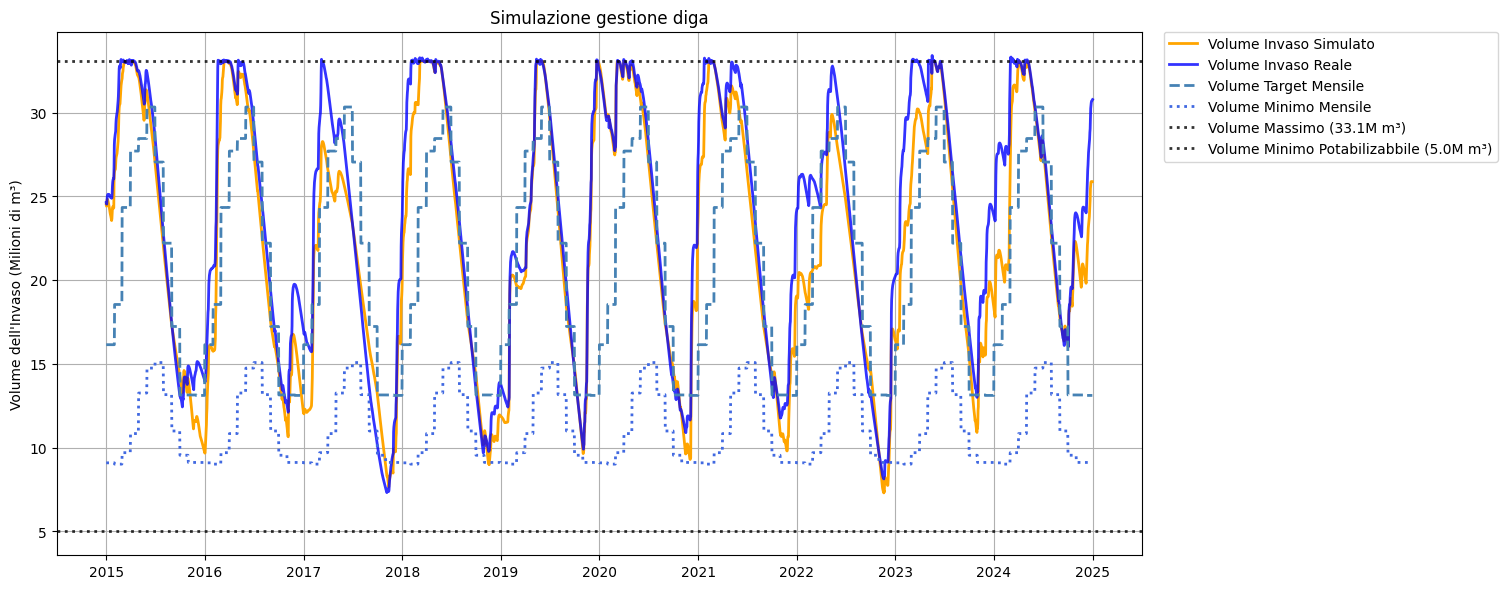


--- RIEPILOGO DELLE METRICHE ---
Errore medio assoluto del volume: 3.77 M m³
Deviazione standard degli errori: 3.27 M m³
Volume minimo raggiunto (media): 7.30 M m³
Volume massimo raggiunto (media): 33.06 M m³
Media dei giorni sotto il minimo dinamico: 70.00
Media dei giorni sopra il massimo: 153.00
Errore medio di previsione: 0.0010 mc/s

--- METRICHE SUI DATI REALI ---
Errore medio assoluto del volume: 4.51 M m³
Deviazione standard degli errori: 4.11 M m³
Volume minimo raggiunto: 7.32 M m³
Volume massimo raggiunto: 33.41 M m³
Giorni sotto il minimo dinamico: 71
Giorni sopra il massimo: 235
Errore medio di previsione: non disponibile nei dati reali


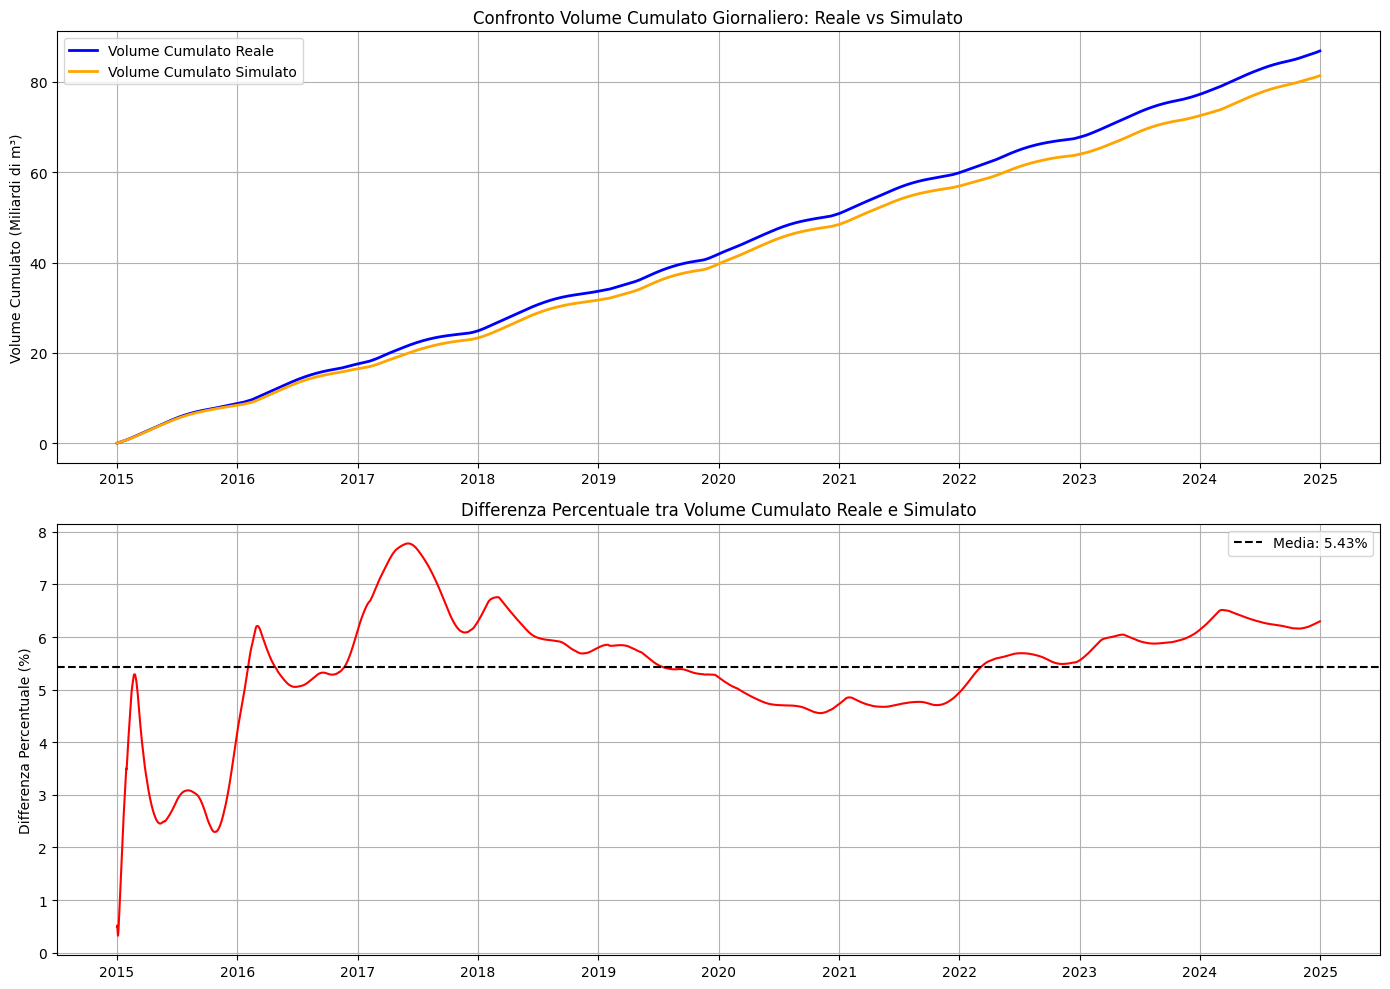

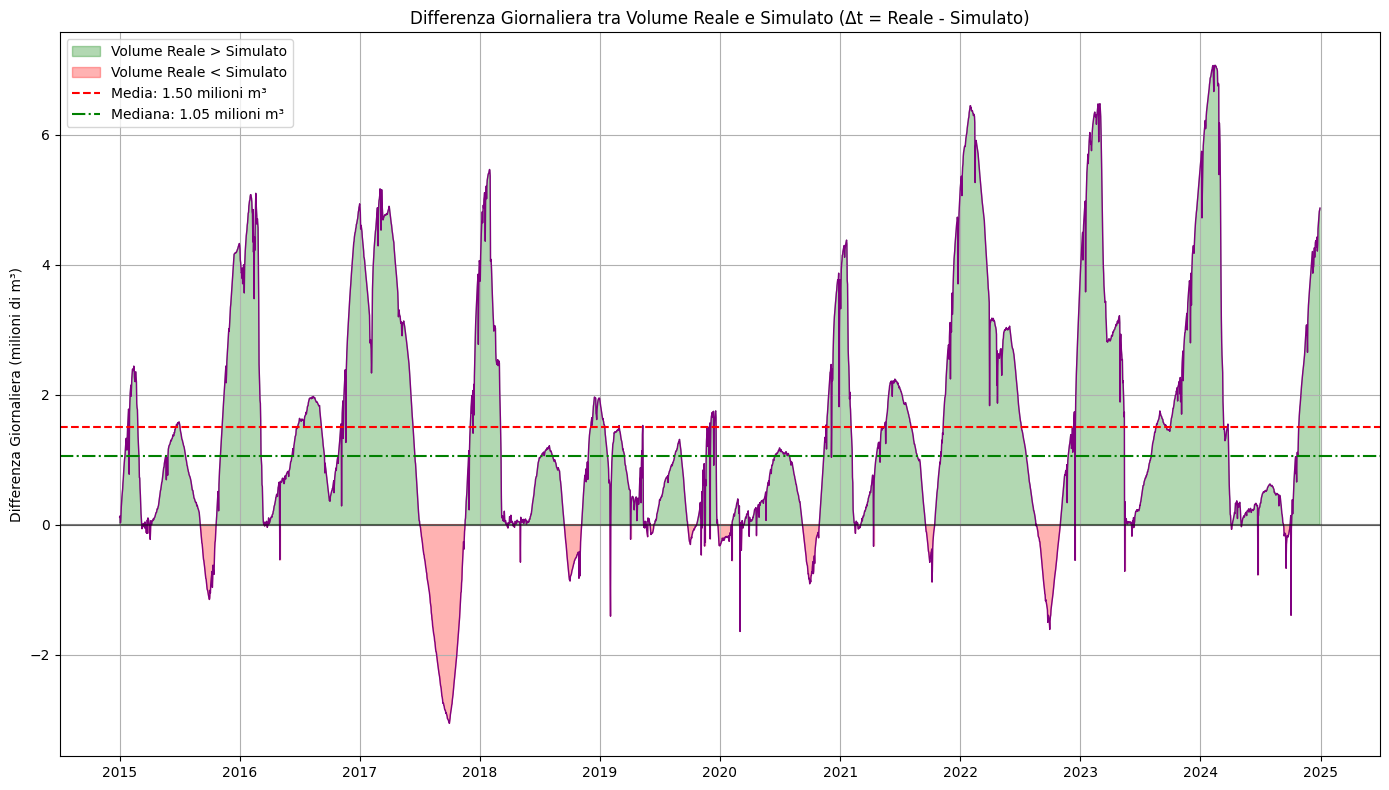

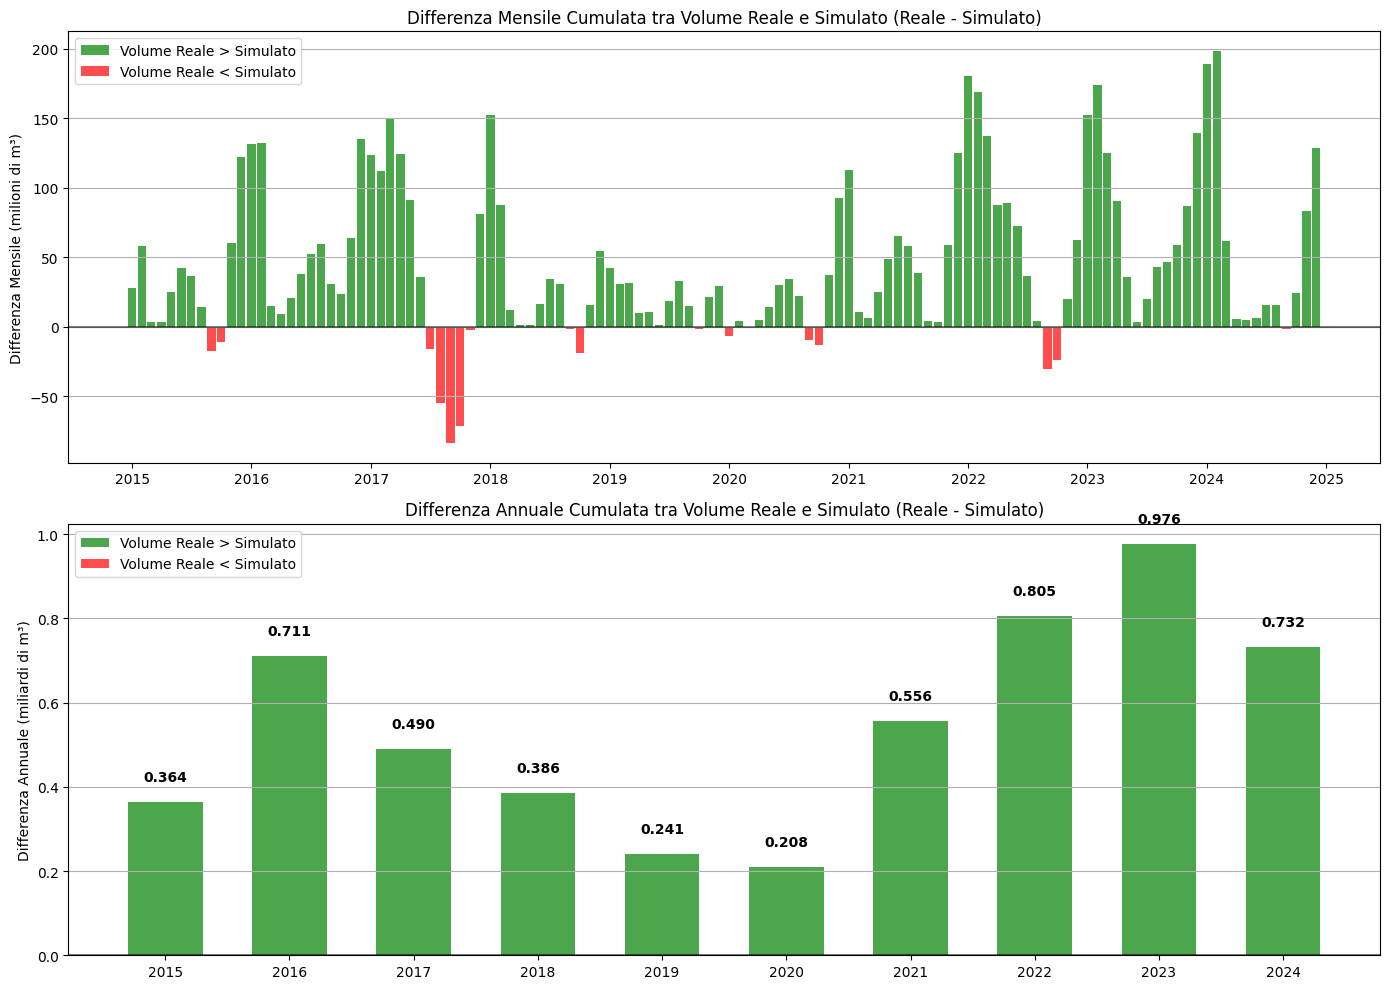


--- STATISTICHE SULLE DIFFERENZE GIORNALIERE ---
Media delle differenze giornaliere: 1.50 milioni di m³
Mediana delle differenze giornaliere: 1.05 milioni di m³

--- STATISTICHE SULLE DIFFERENZE ANNUALI ---
Anno 2015: Differenza = 0.3636 miliardi di m³
Anno 2016: Differenza = 0.7115 miliardi di m³
Anno 2017: Differenza = 0.4901 miliardi di m³
Anno 2018: Differenza = 0.3859 miliardi di m³
Anno 2019: Differenza = 0.2415 miliardi di m³
Anno 2020: Differenza = 0.2084 miliardi di m³
Anno 2021: Differenza = 0.5564 miliardi di m³
Anno 2022: Differenza = 0.8048 miliardi di m³
Anno 2023: Differenza = 0.9756 miliardi di m³
Anno 2024: Differenza = 0.7318 miliardi di m³

--- BILANCIO TOTALE ---
Differenza cumulata nel periodo analizzato: 5.4695 miliardi di m³
Nel complesso, il volume reale è stato MAGGIORE di quello simulato

--- CONFRONTO SIMULAZIONI VS DATI REALI ---
Mean_Abs_Volume_Error: Simulazioni = 3.77 M m³, Reali = 4.51 M m³
Std_Volume_Error: Simulazioni = 3.27 M m³, Reali = 4.11 M m³
Mi

In [ ]:
def calcola_volume_cumulato(df, colonna_volume):

    return df[colonna_volume].cumsum()

def confronta_volumi_cumulati(df_reale, df_simulato, start_date='2015-01-01'):

    # Filtra i dati dalla data di inizio specificata
    df_reale_filtrato = df_reale[df_reale['DATA'] >= pd.to_datetime(start_date)].copy()
    df_simulato_filtrato = df_simulato[df_simulato['Data'] >= pd.to_datetime(start_date)].copy()

    # Assicurati che entrambi i dataframe abbiano la stessa lunghezza
    min_length = min(len(df_reale_filtrato), len(df_simulato_filtrato))
    df_reale_filtrato = df_reale_filtrato.iloc[:min_length].copy()
    df_simulato_filtrato = df_simulato_filtrato.iloc[:min_length].copy()

    # Calcola i volumi cumulati
    df_reale_filtrato['Volume_Cumulato_Reale'] = calcola_volume_cumulato(df_reale_filtrato, 'Volume_invaso_(m3)')
    df_simulato_filtrato['Volume_Cumulato_Simulato'] = calcola_volume_cumulato(df_simulato_filtrato, 'Volume_Reale')

    # Crea un DataFrame di confronto
    df_confronto = pd.DataFrame({
        'Data': df_reale_filtrato['DATA'],
        'Volume_Cumulato_Reale': df_reale_filtrato['Volume_Cumulato_Reale'],
        'Volume_Cumulato_Simulato': df_simulato_filtrato['Volume_Cumulato_Simulato']
    })

    # Calcola le differenze (senza valore assoluto per la differenza assoluta)
    df_confronto['Differenza_Assoluta'] = df_confronto['Volume_Cumulato_Reale'] - df_confronto['Volume_Cumulato_Simulato']
    df_confronto['Differenza_Percentuale'] = (df_confronto['Differenza_Assoluta'] / df_confronto['Volume_Cumulato_Reale']) * 100

    # Calcola metriche di performance
    diff_assoluta_media = df_confronto['Differenza_Assoluta'].mean()
    diff_percentuale_media = df_confronto['Differenza_Percentuale'].mean()
    differenza_finale = df_confronto['Volume_Cumulato_Reale'].iloc[-1] - df_confronto['Volume_Cumulato_Simulato'].iloc[-1]

    return diff_assoluta_media, diff_percentuale_media, differenza_finale, df_confronto

def visualizza_confronto_volumi_cumulati(df_confronto):

    plt.figure(figsize=(14, 10), dpi=100)

    # Subplot per i volumi cumulati
    plt.subplot(2, 1, 1)
    plt.plot(df_confronto['Data'], df_confronto['Volume_Cumulato_Reale'] / 1e9,
             label='Volume Cumulato Reale', color='blue', linewidth=2)
    plt.plot(df_confronto['Data'], df_confronto['Volume_Cumulato_Simulato'] / 1e9,
             label='Volume Cumulato Simulato', color='orange', linewidth=2)
    plt.ylabel('Volume Cumulato (Miliardi di m³)')
    plt.title('Confronto Volume Cumulato Giornaliero: Reale vs Simulato')
    plt.legend()
    plt.grid(True)

    # Subplot per la differenza percentuale
    plt.subplot(2, 1, 2)
    plt.plot(df_confronto['Data'], df_confronto['Differenza_Percentuale'],
             color='red', linewidth=1.5)
    plt.axhline(y=df_confronto['Differenza_Percentuale'].mean(), color='k', linestyle='--',
                label=f'Media: {df_confronto["Differenza_Percentuale"].mean():.2f}%')
    plt.ylabel('Differenza Percentuale (%)')
    plt.title('Differenza Percentuale tra Volume Cumulato Reale e Simulato')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# FUNZIONE CORRETTA: Calcola la differenza giornaliera tra volumi (senza valore assoluto)
def calcola_differenza_giornaliera(df_reale, df_simulato, start_date='2015-01-01'):

    # Filtra i dati dalla data di inizio specificata
    df_reale_filtrato = df_reale[df_reale['DATA'] >= pd.to_datetime(start_date)].copy()
    df_simulato_filtrato = df_simulato[df_simulato['Data'] >= pd.to_datetime(start_date)].copy()

    # Assicurati che entrambi i dataframe abbiano la stessa lunghezza
    min_length = min(len(df_reale_filtrato), len(df_simulato_filtrato))
    df_reale_filtrato = df_reale_filtrato.iloc[:min_length].copy()
    df_simulato_filtrato = df_simulato_filtrato.iloc[:min_length].copy()

    # Crea un DataFrame con le differenze giornaliere
    df_diff_giornaliera = pd.DataFrame({
        'Data': df_reale_filtrato['DATA'],
        'Volume_Reale': df_reale_filtrato['Volume_invaso_(m3)'],
        'Volume_Simulato': df_simulato_filtrato['Volume_Reale'],
    })

    # Calcola la differenza giornaliera (Δt = Reale - Simulato) - senza valore assoluto
    df_diff_giornaliera['Differenza_Giornaliera'] = df_diff_giornaliera['Volume_Reale'] - df_diff_giornaliera['Volume_Simulato']

    # Calcola statistiche riassuntive
    media_diff = df_diff_giornaliera['Differenza_Giornaliera'].mean()
    mediana_diff = df_diff_giornaliera['Differenza_Giornaliera'].median()

    return df_diff_giornaliera, media_diff, mediana_diff

# FUNZIONE CORRETTA: Visualizza la differenza giornaliera (con segno)
def visualizza_differenza_giornaliera(df_diff_giornaliera, media_diff, mediana_diff):

    plt.figure(figsize=(14, 8), dpi=100)

    # Crea un'area colorata per differenziare valori positivi e negativi
    plt.fill_between(df_diff_giornaliera['Data'],
                    df_diff_giornaliera['Differenza_Giornaliera'] / 1e6,
                    0,
                    where=(df_diff_giornaliera['Differenza_Giornaliera'] >= 0),
                    color='green', alpha=0.3, label='Volume Reale > Simulato')

    plt.fill_between(df_diff_giornaliera['Data'],
                    df_diff_giornaliera['Differenza_Giornaliera'] / 1e6,
                    0,
                    where=(df_diff_giornaliera['Differenza_Giornaliera'] < 0),
                    color='red', alpha=0.3, label='Volume Reale < Simulato')

    plt.plot(df_diff_giornaliera['Data'], df_diff_giornaliera['Differenza_Giornaliera'] / 1e6,
            color='purple', linewidth=1.0)

    plt.axhline(y=media_diff / 1e6, color='r', linestyle='--',
               label=f'Media: {media_diff/1e6:.2f} milioni m³')
    plt.axhline(y=mediana_diff / 1e6, color='g', linestyle='-.',
               label=f'Mediana: {mediana_diff/1e6:.2f} milioni m³')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)

    plt.ylabel('Differenza Giornaliera (milioni di m³)')
    plt.title('Differenza Giornaliera tra Volume Reale e Simulato (Δt = Reale - Simulato)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# FUNZIONE CORRETTA: Calcola differenze mensili e annuali (con segno)
def calcola_differenze_aggregate(df_diff_giornaliera):

    # Aggiungi colonne per mese e anno
    df_temp = df_diff_giornaliera.copy()
    df_temp['Anno'] = df_temp['Data'].dt.year
    df_temp['Mese'] = df_temp['Data'].dt.month

    # Aggregazione mensile - somma le differenze giornaliere
    df_mensile = df_temp.groupby(['Anno', 'Mese']).agg({
        'Volume_Reale': 'sum',
        'Volume_Simulato': 'sum',
        'Differenza_Giornaliera': 'sum'  # Somma le differenze mantenendo i segni
    }).reset_index()

    # Crea una colonna con data dell'inizio mese per il plotting
    df_mensile['Data'] = pd.to_datetime(df_mensile['Anno'].astype(str) + '-' +
                                      df_mensile['Mese'].astype(str) + '-01')

    # Aggregazione annuale - somma le differenze giornaliere
    df_annuale = df_temp.groupby('Anno').agg({
        'Volume_Reale': 'sum',
        'Volume_Simulato': 'sum',
        'Differenza_Giornaliera': 'sum'  # Somma le differenze mantenendo i segni
    }).reset_index()

    return df_mensile, df_annuale

# FUNZIONE CORRETTA: Visualizza differenze mensili e annuali (con segno)
def visualizza_differenze_aggregate(df_mensile, df_annuale):

    # Visualizzazione differenze mensili
    plt.figure(figsize=(14, 10), dpi=100)

    plt.subplot(2, 1, 1)
    # Usa colori diversi per valori positivi e negativi
    colori_mensili = ['green' if x >= 0 else 'red' for x in df_mensile['Differenza_Giornaliera']]
    plt.bar(df_mensile['Data'], df_mensile['Differenza_Giornaliera'] / 1e6,
            width=25, color=colori_mensili, alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    plt.ylabel('Differenza Mensile (milioni di m³)')
    plt.title('Differenza Mensile Cumulata tra Volume Reale e Simulato (Reale - Simulato)')
    plt.grid(True, axis='y')

    # Crea una legenda personalizzata
    from matplotlib.patches import Patch
    plt.legend(handles=[
        Patch(facecolor='green', alpha=0.7, label='Volume Reale > Simulato'),
        Patch(facecolor='red', alpha=0.7, label='Volume Reale < Simulato')
    ])

    # Visualizzazione differenze annuali
    plt.subplot(2, 1, 2)
    # Usa colori diversi per valori positivi e negativi
    colori_annuali = ['green' if x >= 0 else 'red' for x in df_annuale['Differenza_Giornaliera']]
    plt.bar(df_annuale['Anno'], df_annuale['Differenza_Giornaliera'] / 1e9,
            width=0.6, color=colori_annuali, alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    plt.ylabel('Differenza Annuale (miliardi di m³)')
    plt.title('Differenza Annuale Cumulata tra Volume Reale e Simulato (Reale - Simulato)')
    plt.grid(True, axis='y')
    plt.xticks(df_annuale['Anno'])

    # Aggiungi etichette con i valori sopra ogni barra annuale
    for i, v in enumerate(df_annuale['Differenza_Giornaliera']):
        plt.text(df_annuale['Anno'].iloc[i],
                v/1e9 + (0.05 if v >= 0 else -0.15),
                f"{v/1e9:.3f}",
                ha='center',
                fontweight='bold')

    # Aggiungi la stessa legenda del grafico superiore
    plt.legend(handles=[
        Patch(facecolor='green', alpha=0.7, label='Volume Reale > Simulato'),
        Patch(facecolor='red', alpha=0.7, label='Volume Reale < Simulato')
    ])

    plt.tight_layout()
    plt.show()

# Aggiunta alla funzione confronta_metriche
def confronta_metriche(df_metriche_simulazioni, df_metriche_reali, diff_volume_cumulato=None):

    # Calcola medie delle simulazioni
    medie_simulazioni = pd.DataFrame({
        'Simulazione': ['Media Simulazioni'],
        'Mean_Abs_Volume_Error': [df_metriche_simulazioni['Mean_Abs_Volume_Error'].mean()],
        'Std_Volume_Error': [df_metriche_simulazioni['Std_Volume_Error'].mean()],
        'Min_Volume_Reached': [df_metriche_simulazioni['Min_Volume_Reached'].mean()],
        'Max_Volume_Reached': [df_metriche_simulazioni['Max_Volume_Reached'].mean()],
        'Days_Under_Min': [df_metriche_simulazioni['Days_Under_Min'].mean()],
        'Days_Over_Max': [df_metriche_simulazioni['Days_Over_Max'].mean()],
        'Mean_Forecast_Error': [df_metriche_simulazioni['Mean_Forecast_Error'].mean()]
    })

    # Combina le metriche per il confronto
    df_confronto = pd.concat([medie_simulazioni, df_metriche_reali], ignore_index=True)

    # Visualizza confronto
    print("\n--- CONFRONTO SIMULAZIONI VS DATI REALI ---")
    for metrica in ['Mean_Abs_Volume_Error', 'Std_Volume_Error', 'Min_Volume_Reached',
                    'Max_Volume_Reached', 'Days_Under_Min', 'Days_Over_Max']:

        if 'Volume' in metrica and metrica != 'Days_Under_Min' and metrica != 'Days_Over_Max':
            # Formatta i volumi in milioni di m³
            print(f"{metrica}: Simulazioni = {medie_simulazioni[metrica].values[0]/1e6:.2f} M m³, "
                  f"Reali = {df_metriche_reali[metrica].values[0]/1e6:.2f} M m³")
        else:
            print(f"{metrica}: Simulazioni = {medie_simulazioni[metrica].values[0]:.2f}, "
                  f"Reali = {df_metriche_reali[metrica].values[0]:.2f}")

    # Aggiungi le metriche sui volumi cumulati se disponibili
    if diff_volume_cumulato is not None:
        diff_assoluta_media, diff_percentuale_media, differenza_finale = diff_volume_cumulato
        durata_giorni = 3652  # Utilizziamo un valore fisso basato sulla durata della simulazione
        diff_m3_per_second = differenza_finale / durata_giorni

        print(f"\n--- CONFRONTO VOLUMI CUMULATI ---")
        print(f"Differenza media: {diff_assoluta_media/1e9:.4f} miliardi di m³ (Reale - Simulato)")
        print(f"Differenza percentuale media: {diff_percentuale_media:.2f}%")
        print(f"Differenza finale: {differenza_finale:.0f} m³")
        print(f"Differenza media giornaliera in m³/s: {diff_m3_per_second:.2f} m³/s")
    return df_confronto

def run_monte_carlo_example():
    # ... [codice esistente]

    # Esegui il test Monte Carlo
    try:
        risultati, metriche = main_monte_carlo_test(
            df,
            prelievi_minimi_mensili,
            volumi_minimi_necessari,
            target_mensili=volumi_target_fattibili,  # Passa i target se disponibili
            num_simulazioni=1,
            durata_simulazione=3652
        )
    except NameError:
        # Se volumi_target_fattibili non è disponibile, lasciamo che il test calcoli i target dai dati storici
        risultati, metriche = main_monte_carlo_test(
            df,
            prelievi_minimi_mensili,
            volumi_minimi_necessari,
            num_simulazioni=1,
            durata_simulazione=3652
        )

    # Calcola le metriche sui dati reali per confronto
    try:
        # Usa gli stessi target delle simulazioni se disponibili
        target_mensili = volumi_target_fattibili
    except NameError:
        # Calcola i target dai dati storici come fatto nella funzione main_monte_carlo_test
        target_mensili = np.zeros(12)
        for mese in range(1, 13):
            target_mensili[mese-1] = df[df['DATA'].dt.month == mese]['Volume_invaso_(m3)'].mean()

    # Calcola le metriche sui dati reali usando la stessa durata della simulazione
    metriche_reali = calcola_metriche_dati_reali(
        df,
        target_mensili,
        volumi_minimi_necessari,
        durata_analisi=3652  # Usa la stessa durata delle simulazioni
    )

    # Scegli la prima simulazione come esempio
    sim_idx = 0
    if risultati and len(risultati) > sim_idx:
        # CONFRONTO VOLUMI CUMULATI
        diff_assoluta_media, diff_percentuale_media, differenza_finale, df_confronto_volumi = confronta_volumi_cumulati(
            df.iloc[:3652],
            risultati[sim_idx],
            start_date='2015-01-01'
        )

        # Visualizza il confronto dei volumi cumulati
        visualizza_confronto_volumi_cumulati(df_confronto_volumi)

        # CALCOLA E VISUALIZZA DIFFERENZE GIORNALIERE (CON SEGNO: + quando reale > simulato, - quando reale < simulato)
        df_diff_giornaliera, media_diff, mediana_diff = calcola_differenza_giornaliera(
            df.iloc[:3652],
            risultati[sim_idx],
            start_date='2015-01-01'
        )

        # Visualizza le differenze giornaliere
        visualizza_differenza_giornaliera(df_diff_giornaliera, media_diff, mediana_diff)

        # CALCOLA E VISUALIZZA DIFFERENZE MENSILI E ANNUALI
        df_mensile, df_annuale = calcola_differenze_aggregate(df_diff_giornaliera)

        # Visualizza le differenze aggregate
        visualizza_differenze_aggregate(df_mensile, df_annuale)

        # Stampa statistiche riassuntive
        print("\n--- STATISTICHE SULLE DIFFERENZE GIORNALIERE ---")
        print(f"Media delle differenze giornaliere: {media_diff/1e6:.2f} milioni di m³")
        print(f"Mediana delle differenze giornaliere: {mediana_diff/1e6:.2f} milioni di m³")

        print("\n--- STATISTICHE SULLE DIFFERENZE ANNUALI ---")
        for idx, row in df_annuale.iterrows():
            print(f"Anno {int(row['Anno'])}: Differenza = {row['Differenza_Giornaliera']/1e9:.4f} miliardi di m³")

        # Calcola il bilanciamento totale
        bilancio_totale = df_diff_giornaliera['Differenza_Giornaliera'].sum()
        print(f"\n--- BILANCIO TOTALE ---")
        print(f"Differenza cumulata nel periodo analizzato: {bilancio_totale/1e9:.4f} miliardi di m³")

        if bilancio_totale > 0:
            print("Nel complesso, il volume reale è stato MAGGIORE di quello simulato")
        else:
            print("Nel complesso, il volume reale è stato MINORE di quello simulato")

        # Confronta le metriche includendo il confronto sui volumi cumulati
        df_confronto = confronta_metriche(
            metriche,
            metriche_reali,
            diff_volume_cumulato=(diff_assoluta_media, diff_percentuale_media, differenza_finale)
        )
    else:
        # Confronta le metriche senza il confronto sui volumi cumulati
        df_confronto = confronta_metriche(metriche, metriche_reali)

    print("Simulazione Monte Carlo completata e confrontata con i dati reali!")

    return risultati, metriche, metriche_reali, df_confronto

# Se questo script viene eseguito direttamente
if __name__ == "__main__":
    # Importazioni necessarie (aggiunte per completezza)
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Esegui il test Monte Carlo e il confronto con i dati reali
    risultati_mc, metriche_mc, metriche_reali, confronto = run_monte_carlo_example()
    print("Analisi completata!")